In [1]:
from typing import List, Tuple
from math import log10

import numpy as np
from numpy.linalg.linalg import norm
from numpy.typing import NDArray
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint

sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})

## 1. Normalization
### Given 1 - D data set X = {-5.0, 23.0, 17.6, 7.23, 1.11}, normalize the data set using:

In [2]:
xs = [-5.0, 23.0, 17.6, 7.23, 1.11]

### (a) decimal scaling on interval [-1, 1]

In [3]:
def decimal_scale(xs: List[float]):
    """
    v' = v / 10^j where j is the smallest integer such that Max(|ν’|) < 1
    """
    j = int(log10(max(xs))) + 1
    xs_scaled = [v / (10**j) for v in xs]
    return xs_scaled

In [4]:
decimal_scale(xs)

[-0.05, 0.23, 0.17600000000000002, 0.0723, 0.0111]

### (b) min–max normalization on interval [0, 1]

In [5]:
def min_max_scale(xs: List[float], new_min=0, new_max=1):
    """
    v' = newMinV + ((v - minV) / (maxV - minV)) * (newMaxV - newMinV)
    """
    max_x, min_x = max(xs), min(xs)
    scale = lambda v: new_min + (((v - min(xs)) / (max(xs) - min(xs))) * (new_max - new_min)) 
    xs_scaled = [scale(v) for v in xs]
    return xs_scaled

In [6]:
min_max_scale(xs)

[0.0, 1.0, 0.8071428571428572, 0.4367857142857143, 0.21821428571428572]

### (c) standard deviation normalization

In [7]:
def mean(xs: List[float]):
    return sum(xs) / len(xs)

def std(xs: List[float], ddof=0):
    """
    ddof: int (delta defrees of freedom) - 0 for population std, 1 for sample std
    """
    c = mean(xs)
    n = len(xs)
    sum_squared_deviations = sum((x-c)**2 for x in xs)
    pvar = sum_squared_deviations / (n-ddof)
    return pvar**0.5

In [8]:
def std_scale(xs: List[float]):
    """
    v' = (v  - mean) / std
    std of the entire population is calculated.
    """
    mean_xs = mean(xs)
    std_xs = std(xs)
    xs_scaled = [
        (v - mean_xs) / std_xs for v in xs
    ]
    return xs_scaled

In [9]:
xs_std_scaled = std_scale(xs)
xs_std_scaled

[-1.337795819876786,
 1.3789348848338325,
 0.8549939632110705,
 -0.15116665849782654,
 -0.7449663696702903]

اگر به درستی به روش 

standard deviation

داده‌ها را نرمال‌سازی کرده باشیم، باید میانگین داده‌ها صفر و انحراف معیارشان یک باشد..

In [10]:
new_mean = mean(xs_std_scaled)
new_std = std(xs_std_scaled)
print(f'new_mean: {new_mean}, new_std: {new_std}')

new_mean: 2.2204460492503132e-17, new_std: 1.0


## 2. Outlier Removal
### The number of children for different patients in a database is given with a vector
### C = {3 1 0 2 7 3 6 4 2 0 0 10 15 6}:
### Find the outliers in set C using standard statistical parameters mean and variance.
### If the threshold value is changed from ±3 standard deviations to ±2 standard deviations, what additional outliers are found?

In [11]:
c =  [3, 1, 0, 2, 7, 3, 6, 4, 2, 0, 0, 10, 15, 6]
c

[3, 1, 0, 2, 7, 3, 6, 4, 2, 0, 0, 10, 15, 6]

In [12]:
def get_outliers(xs: List[float], interval_degree: int = 3):
    mean_xs = mean(xs)
    std_xs = std(xs)
    is_outlier = lambda x: (x < mean_xs - interval_degree * std_xs) or (x > mean_xs + interval_degree * std_xs)
    outliers = [x for x in xs if is_outlier(x)]
    return outliers

ابتدا داده‌ّهای پرت را برای بازه‌ی

+- 3 std

محاسبه می‌کنیم.

In [13]:
get_outliers(c, interval_degree=3)

[]

سپس با بازه‌ی

+- 2std

تکرار می‌کنیم.

In [14]:
get_outliers(c, interval_degree=2)

[15]

## 3. Kmeans Clustering
### Implement Kmeans clustering algorithm from scratch, and then apply your model on IRIS dataset. Describe the IRIS dataset. 

In [15]:
iris = pd.read_csv('iris_data.csv', names=["Sepal_Length", "Sepal_Width", "Petal_Length", "Petal_Width", "class"])
iris.head()

Sepal_Length  Sepal_Width  Petal_Length  Petal_Width        class
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa

دیتاست آیریس، شامل ۱۵۰ نمونه مشاهده از ۳ نوع گل

Iris setosa (زنبق نوک‌زبر)

Iris versicolor (زنبق رنگارنگ)

Iris Iris virginica (زنبق ویرجینیا)

می‌باشد. برای هر نمونه، طول و عرض

کاس‌برگ (Sepal)

گل‌برگ (Petal)

به سانتی‌متر گزارش شده‌اند.

بنا بر این دیتاست، شامل ۱۵۰ سطر، با ۴ ستون فیچر و ۱ ستون کلاس می‌باشد.

از هر کلاس، به تعداد برابر ۵۰ نمونه داریم.


در ادامه پیش از آن که الگوریتم 

K Means

را پیاده کنیم، ابتدا یک بار بر اساس ابعاد کاسبرگ و سپس بر اساس ابعاد گلبرگ به مصورسازی داده‌ها می‌پردازیم.

توضیح رسمی مرجع این مجموعه داده در ادامه آورده شده است.

The data set contains 3 classes of 50 instances each,
       where each class refers to a type of iris plant.  
       
One class is
linearly separable from the other 2; the latter are NOT linearly
separable from each other.


Predicted attribute: class of iris plant.


Number of Instances: 150 (50 in each of three classes)


Number of Attributes: 4 numeric, predictive attributes and the class


Attribute Information:
1. sepal length in cm
2. sepal width in cm
3. petal length in cm
4. petal width in cm
5. class: 
  -- Iris Setosa
  -- Iris Versicolour
  -- Iris Virginica

<AxesSubplot:xlabel='Sepal_Length', ylabel='Sepal_Width'>

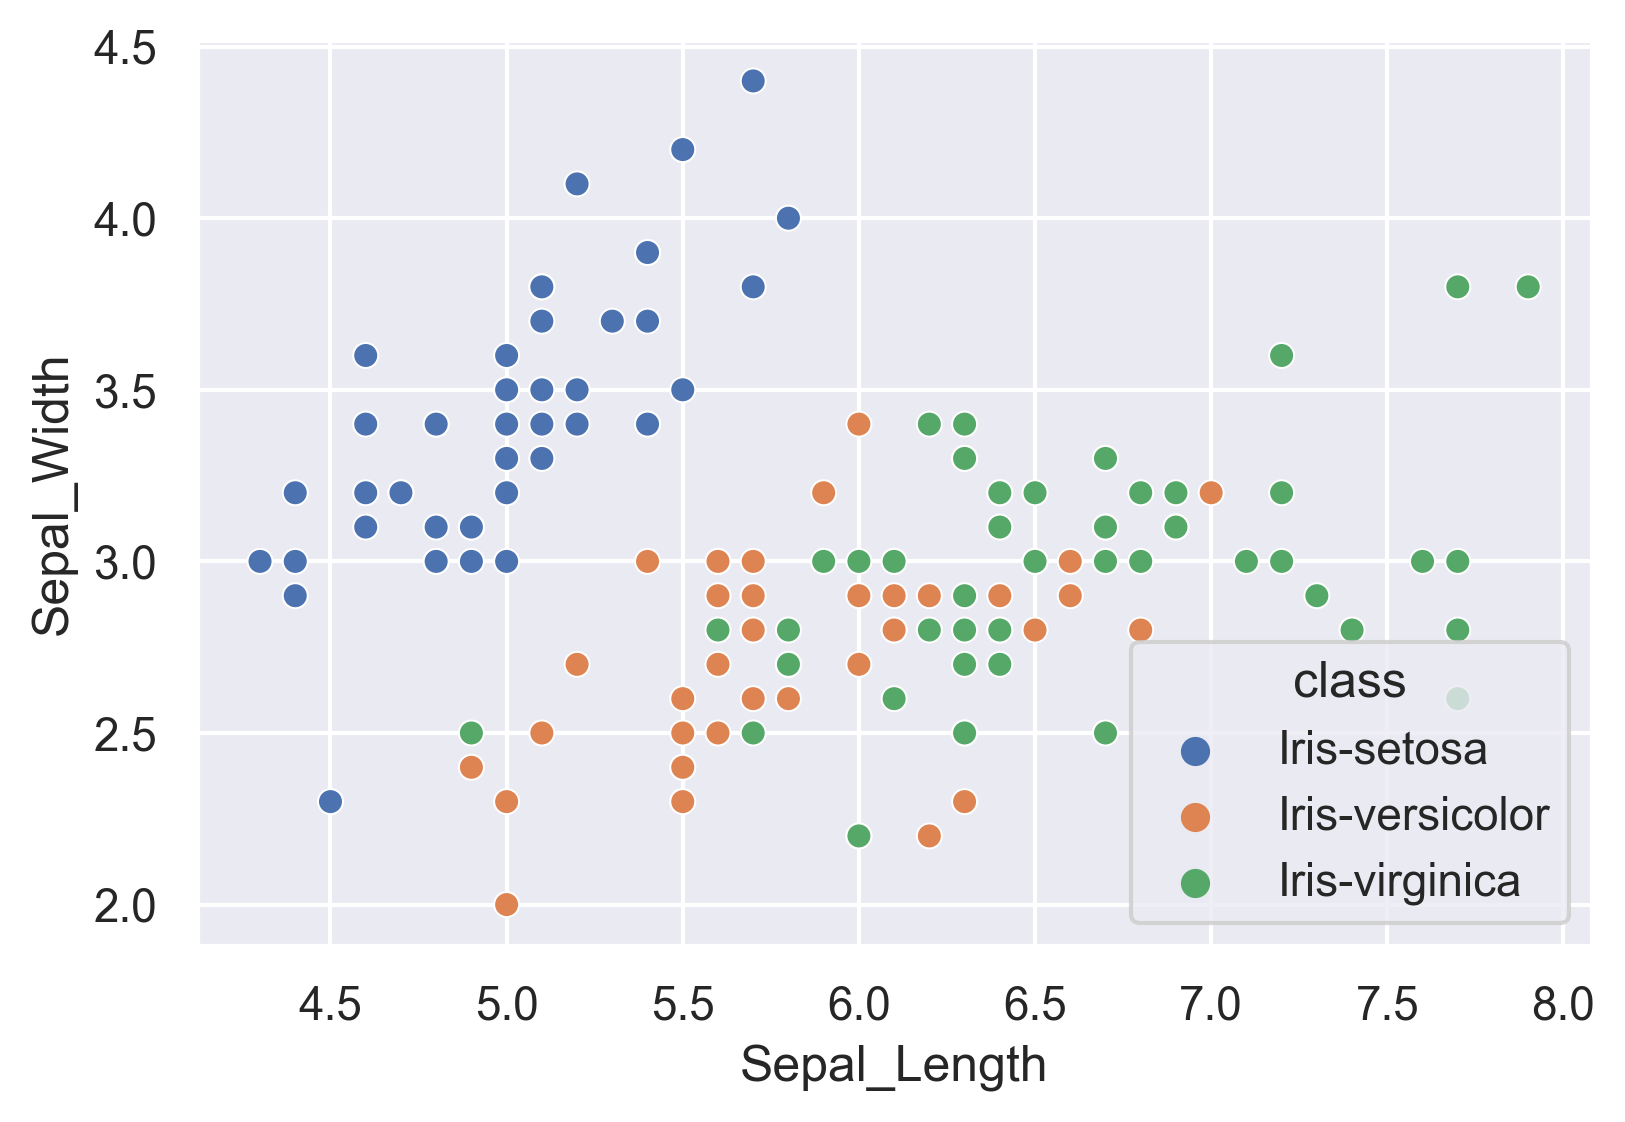

In [16]:
sns.scatterplot(data=iris, x="Sepal_Length", y="Sepal_Width", hue="class")

<AxesSubplot:xlabel='Petal_Length', ylabel='Petal_Width'>

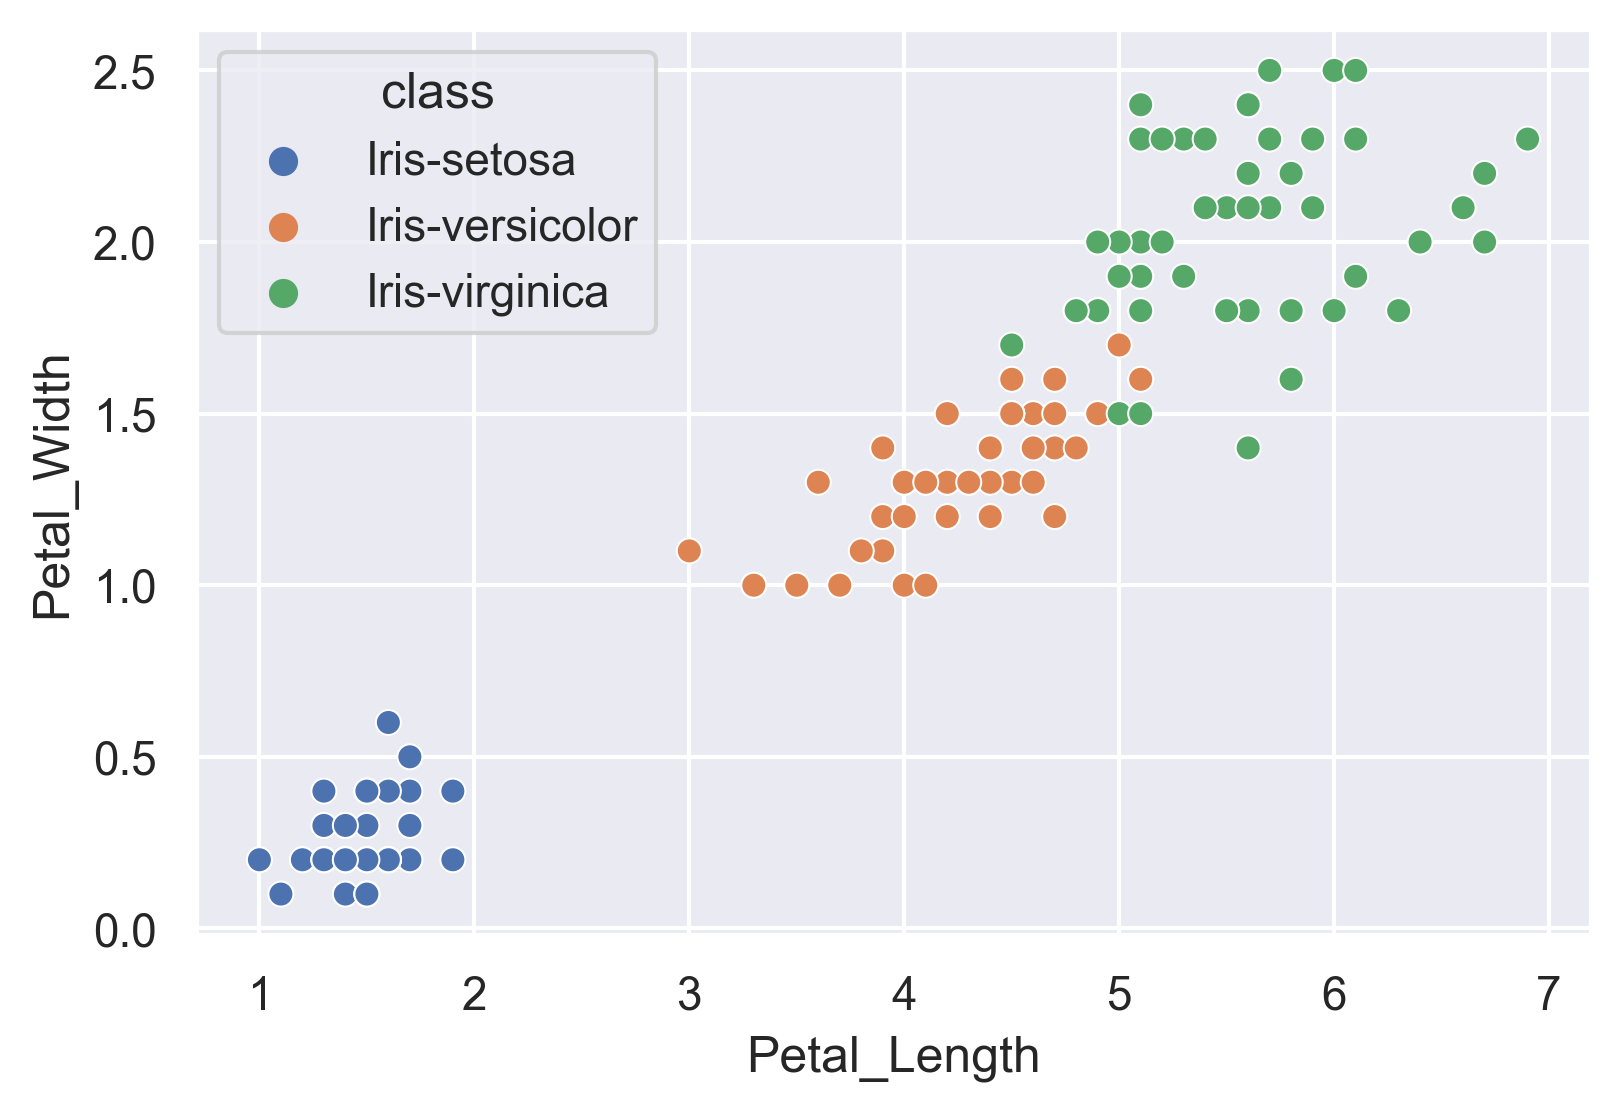

In [17]:
sns.scatterplot(data=iris, x="Petal_Length", y="Petal_Width", hue="class")

مشاهده شد که داده‌ها بر اساس ابعاد کاسبرگ به خوبی از هم جدا نشده‌اند، اما برای ابعاد گلبرگ جداسازی به خوبی اتفاق افتاده است.

In [18]:
def compute_centroids(xs: pd.DataFrame, ys: pd.DataFrame, num_clusters: int) -> List[NDArray]:
    centroids = []
    for cluster_i in range(num_clusters):
        cluster_i_xs = xs.loc[ys['cluster'] == cluster_i]
        centroid_i = np.mean(cluster_i_xs.to_numpy(), axis=0)
        centroids.append(centroid_i)
    return centroids


def compute_wcv(xs: pd.DataFrame, ys: pd.DataFrame, num_clusters: int, centroids: List[NDArray]):
    wcvs = []
    for cluster_i in range(num_clusters):
        cluster_i_xs = xs.loc[ys['cluster'] == cluster_i].to_numpy()
        centroid_i = centroids[cluster_i]

        distances = [np.sum(np.square(x - centroid_i)) for x in cluster_i_xs]
        wcv_i = 2 * sum(distances) / len(distances)
        wcvs.append(wcv_i)

    wcv_mean = sum(wcvs) / len(wcvs)
    return wcv_mean


def assign(point: NDArray, centroids: List[NDArray]) -> int:
    distances = [
        norm(point - centroid_i) for centroid_i in centroids
    ]
    new_cluster = distances.index(min(distances))
    return new_cluster


class KMeans:
    def __init__(self, df: pd.DataFrame, num_clusters=4):
        self.num_clusters = num_clusters
        self.centroids = [None for _ in range(self.num_clusters)]
        self.df = df

    def fit(self, with_visualization=False):
        ys = pd.DataFrame()
        xs = self.df.iloc[:, :4]

        ys['cluster'] = xs.apply(lambda _: randint(0, self.num_clusters - 1), axis=1)

        iteration = 0
        while True:
            iteration += 1

            centroids = compute_centroids(xs, ys, self.num_clusters)

            ys['prev_cluster'] = ys['cluster']
            ys['cluster'] = xs.apply(
                lambda row: assign(row.to_numpy(), centroids),
                axis=1
            )

            wcv = compute_wcv(xs, ys, self.num_clusters, centroids)
            info = f'Iteration #{iteration}, Mean WCV: {wcv}'
            print(info)
            if with_visualization:
                plt.figure(iteration)
                sns.scatterplot(data=self.df, x="Petal_Length", y="Petal_Width", hue=ys['cluster']).set_title(info)

            did_clusters_change = not ys['cluster'].equals(ys['prev_cluster'])
            if not did_clusters_change:
                break

        self.df['cluster'] = ys['cluster']
        self.centroids = centroids

در ادامه الگوریتم را یک بار با تعداد خوشه‌ی ۴ و بار دیگر با تعداد خوشه‌ی ۳ روی داده‌ها اجرا می‌کنیم.
معیار برتری خوشه‌بندی، طبق ارائه‌ی کلاس، معیار

wcv

است که میانگین فواصل داده‌های یک خوشه را محاسبه می‌کند.

Iteration #1, Mean WCV: 3.9224589586833956
Iteration #2, Mean WCV: 1.0594142063180931
Iteration #3, Mean WCV: 1.0303924968403693
Iteration #4, Mean WCV: 0.9648273201449165
Iteration #5, Mean WCV: 0.8903454612665598
Iteration #6, Mean WCV: 0.8306441366541322
Iteration #7, Mean WCV: 0.8060394038905117
Iteration #8, Mean WCV: 0.7927640463146371
Iteration #9, Mean WCV: 0.789326626585127
Iteration #10, Mean WCV: 0.7887906269211917
Iteration #11, Mean WCV: 0.7888500398920608
Iteration #12, Mean WCV: 0.7883881574003883


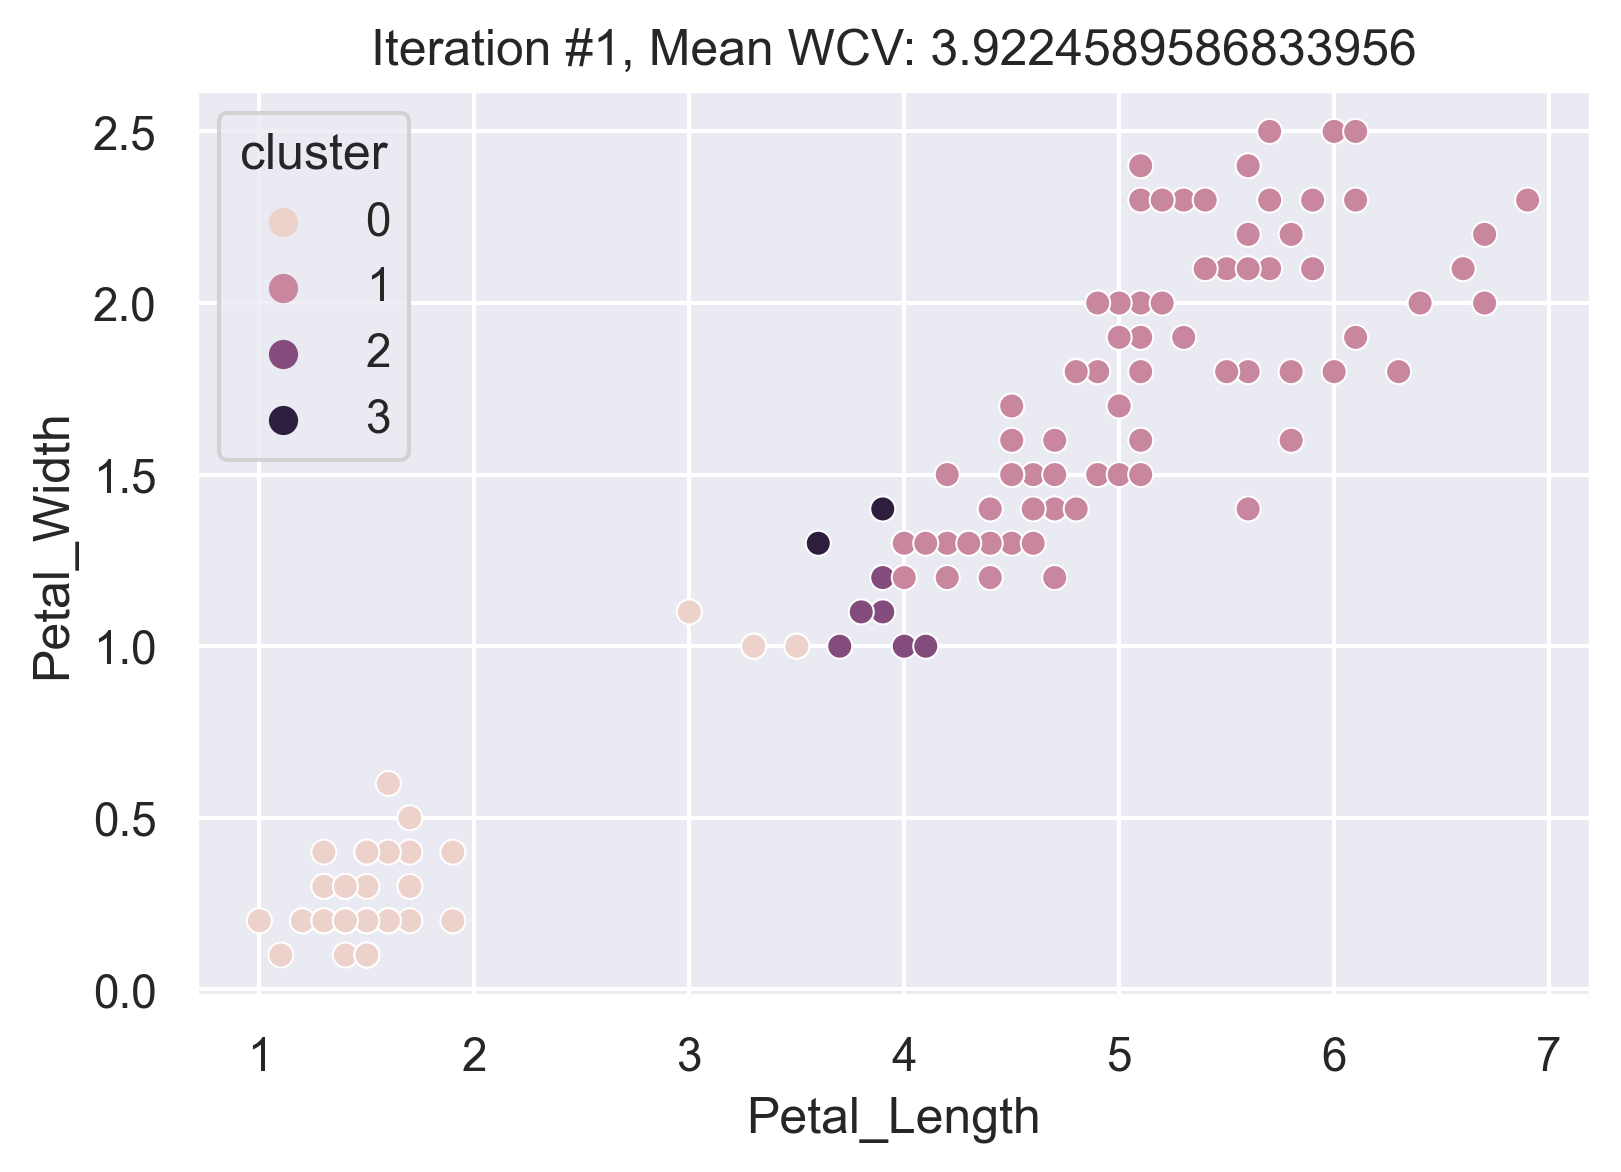

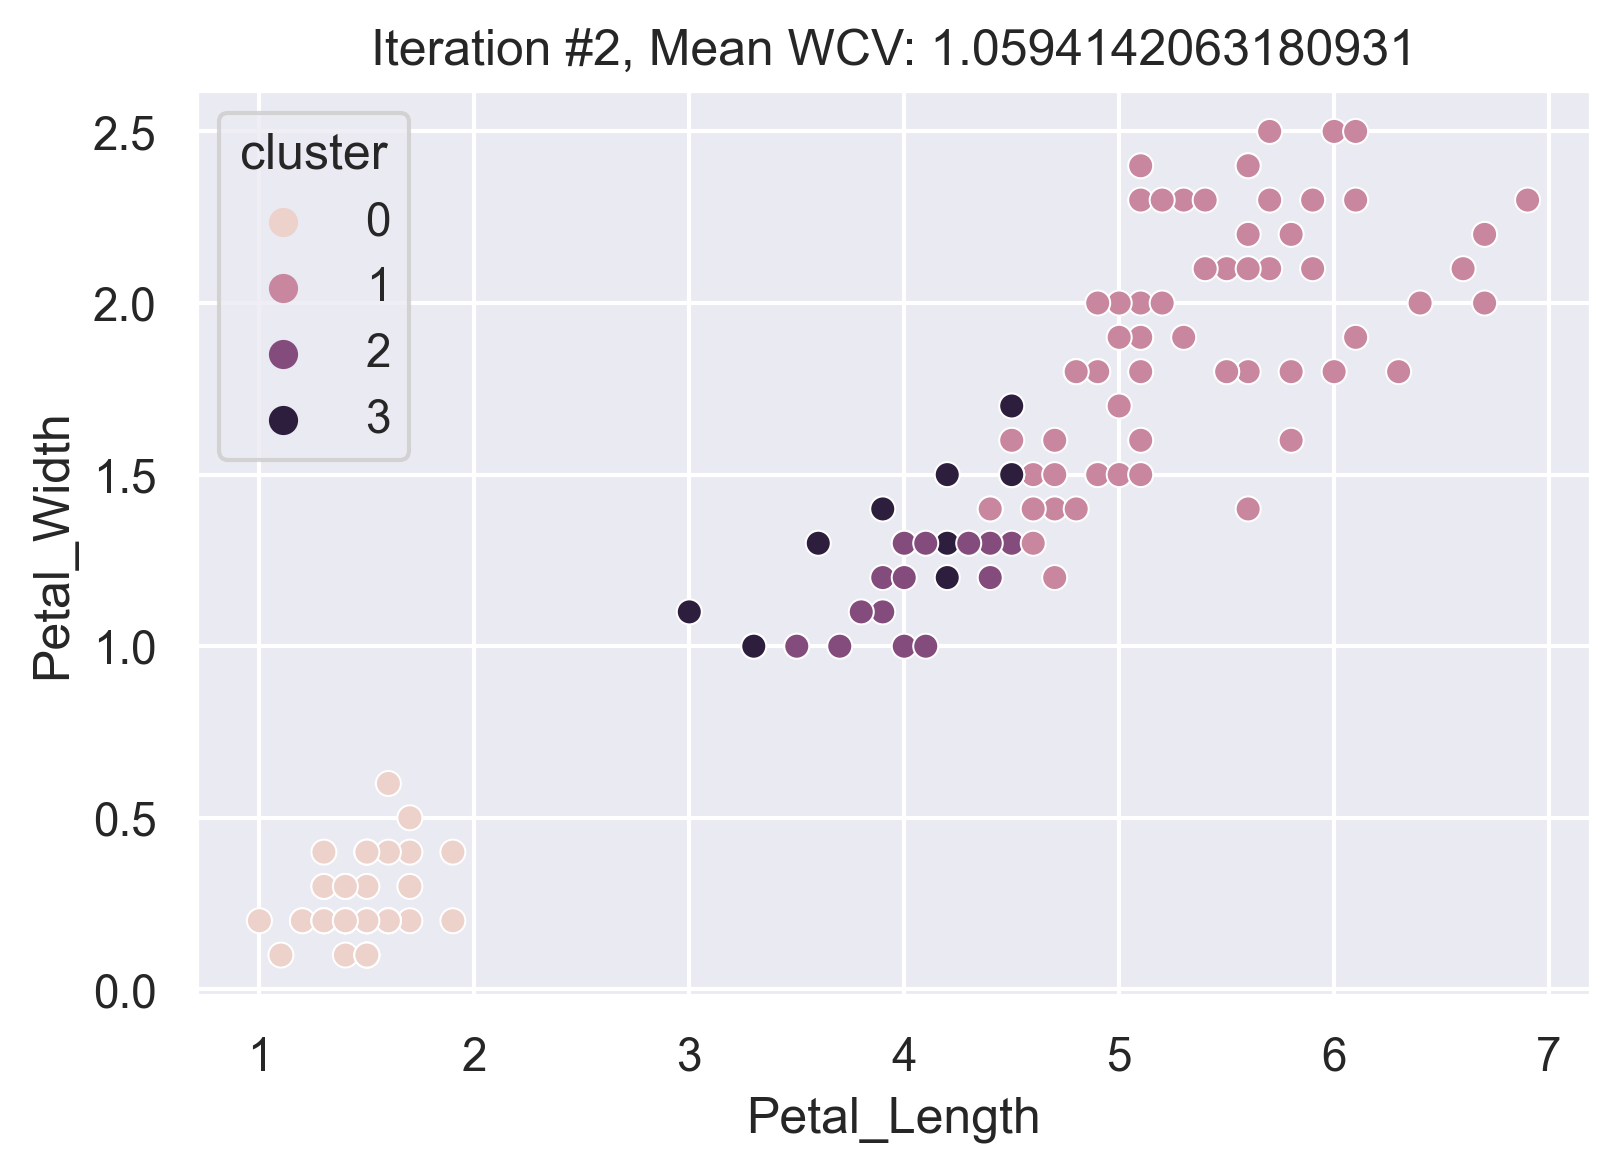

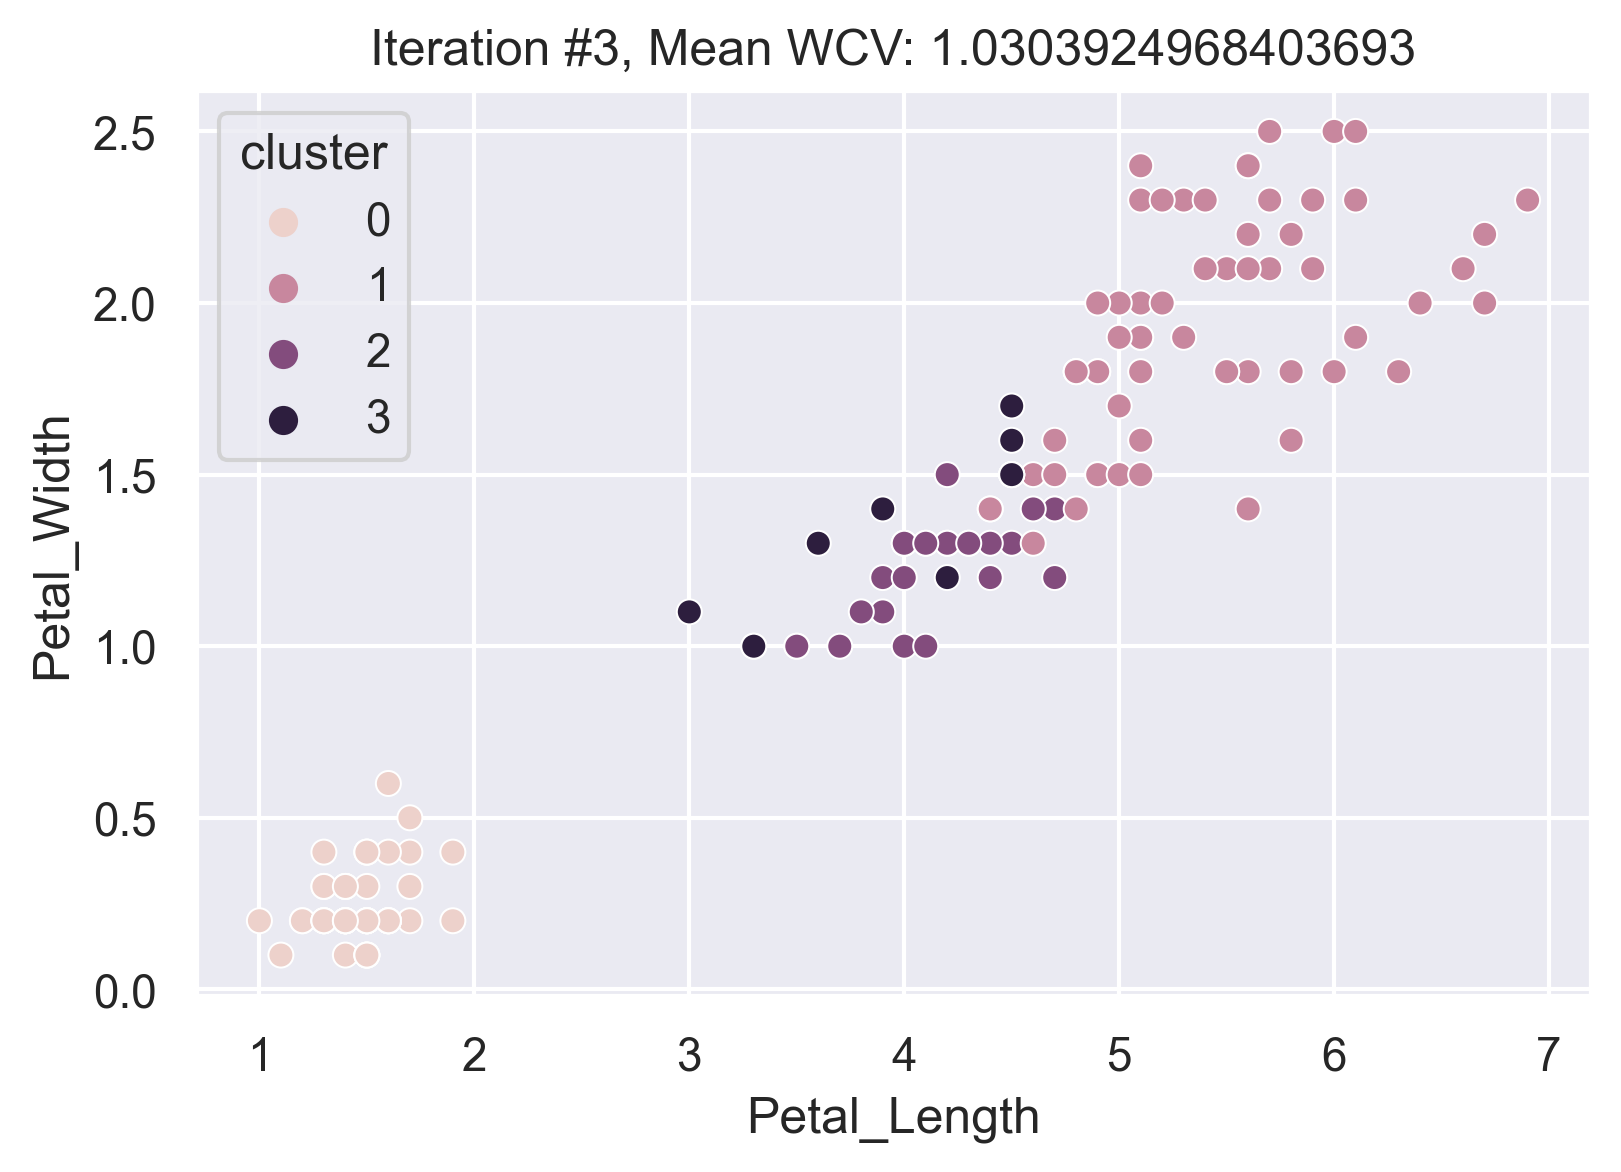

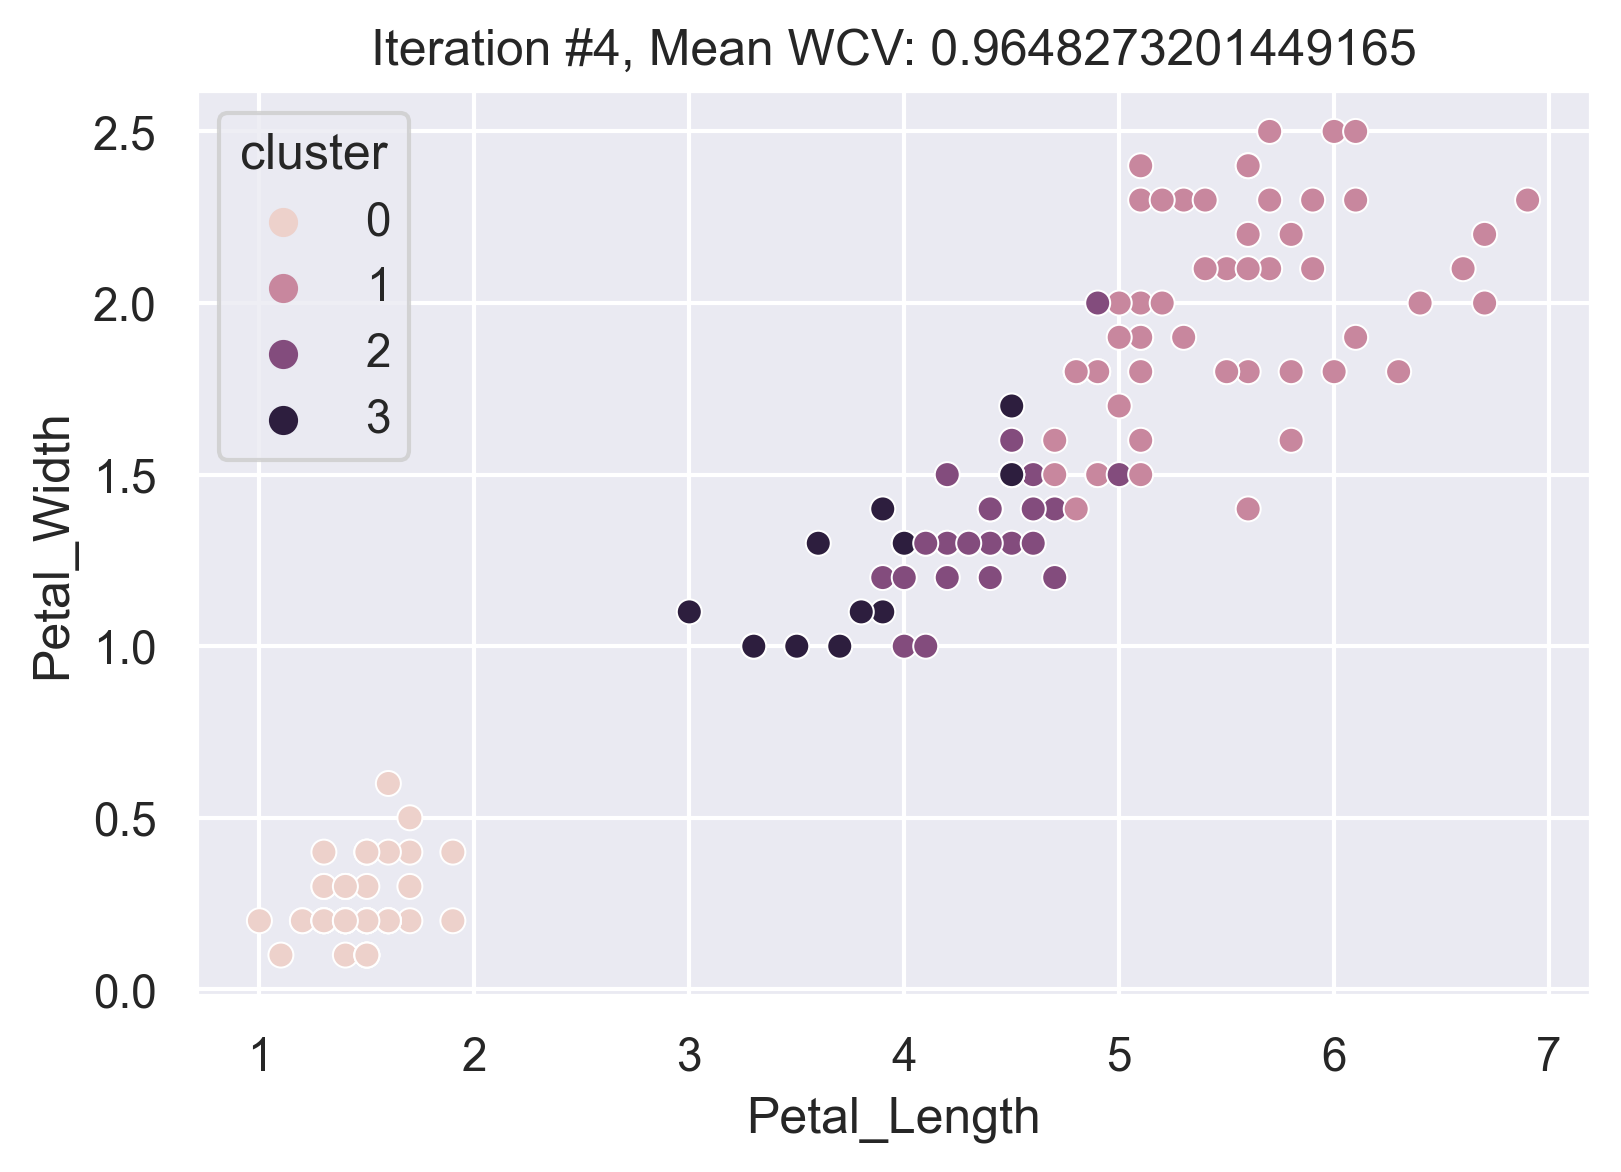

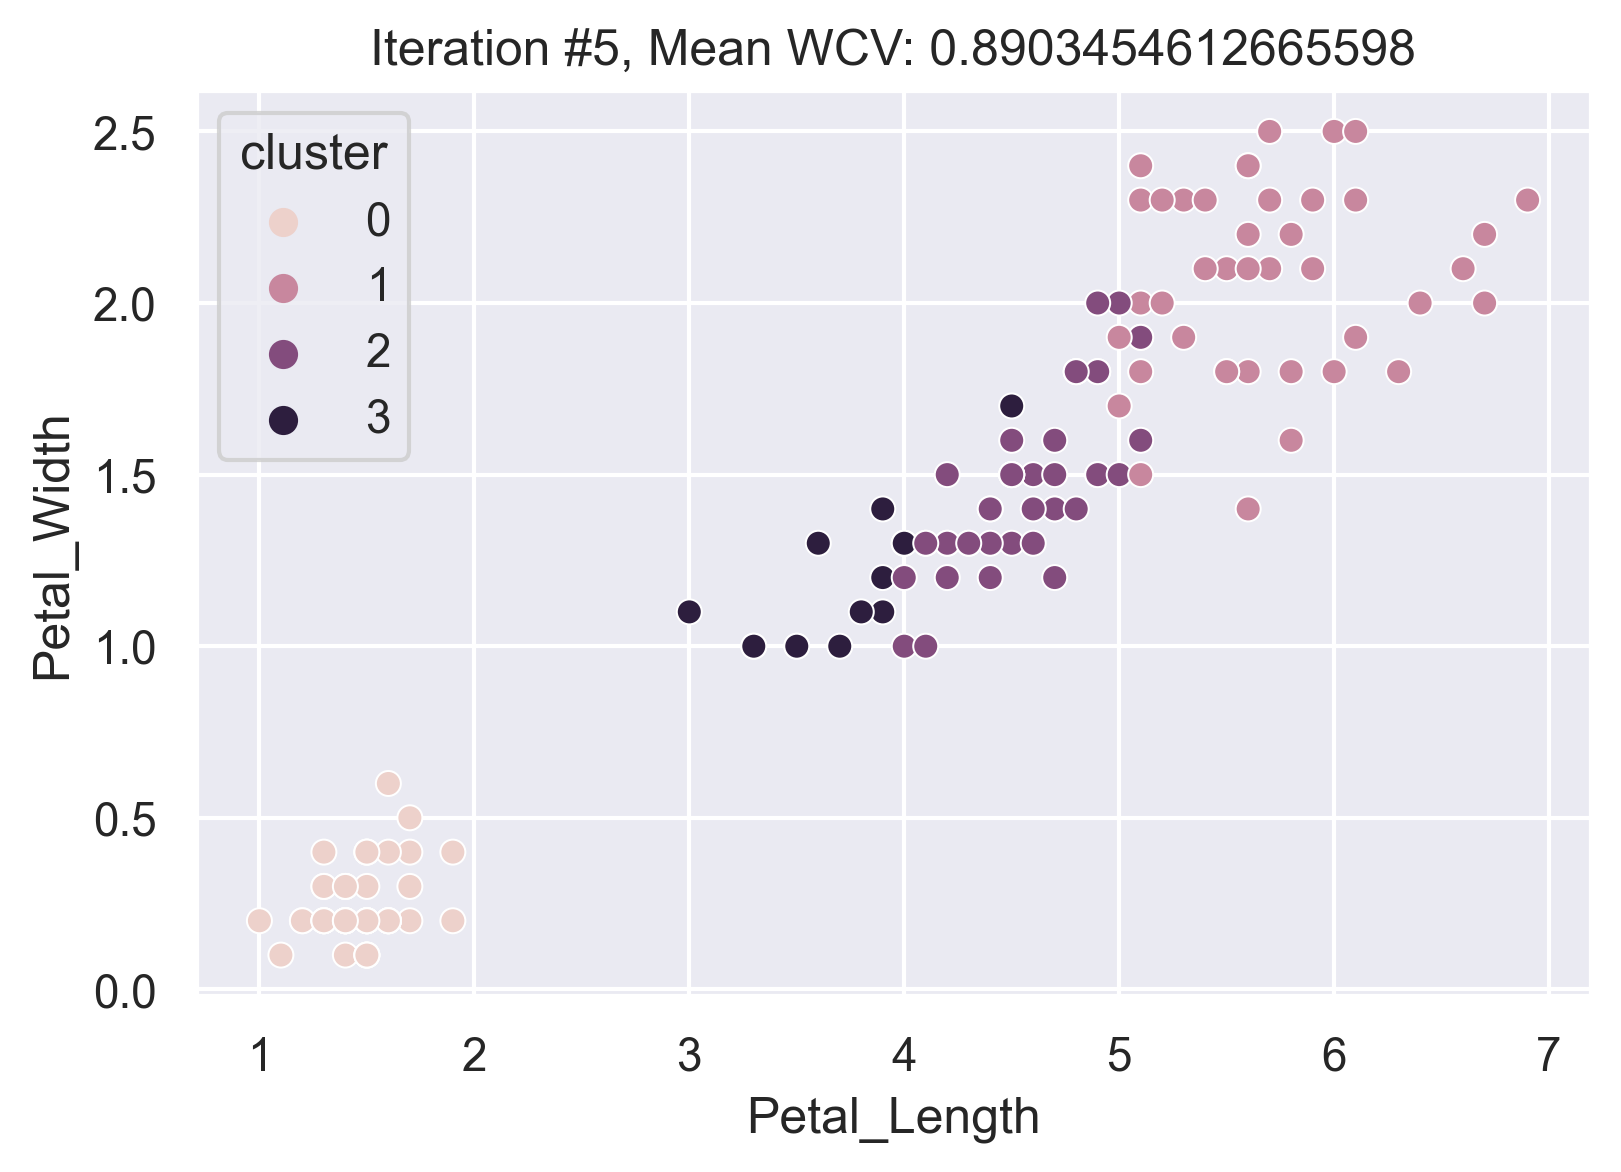

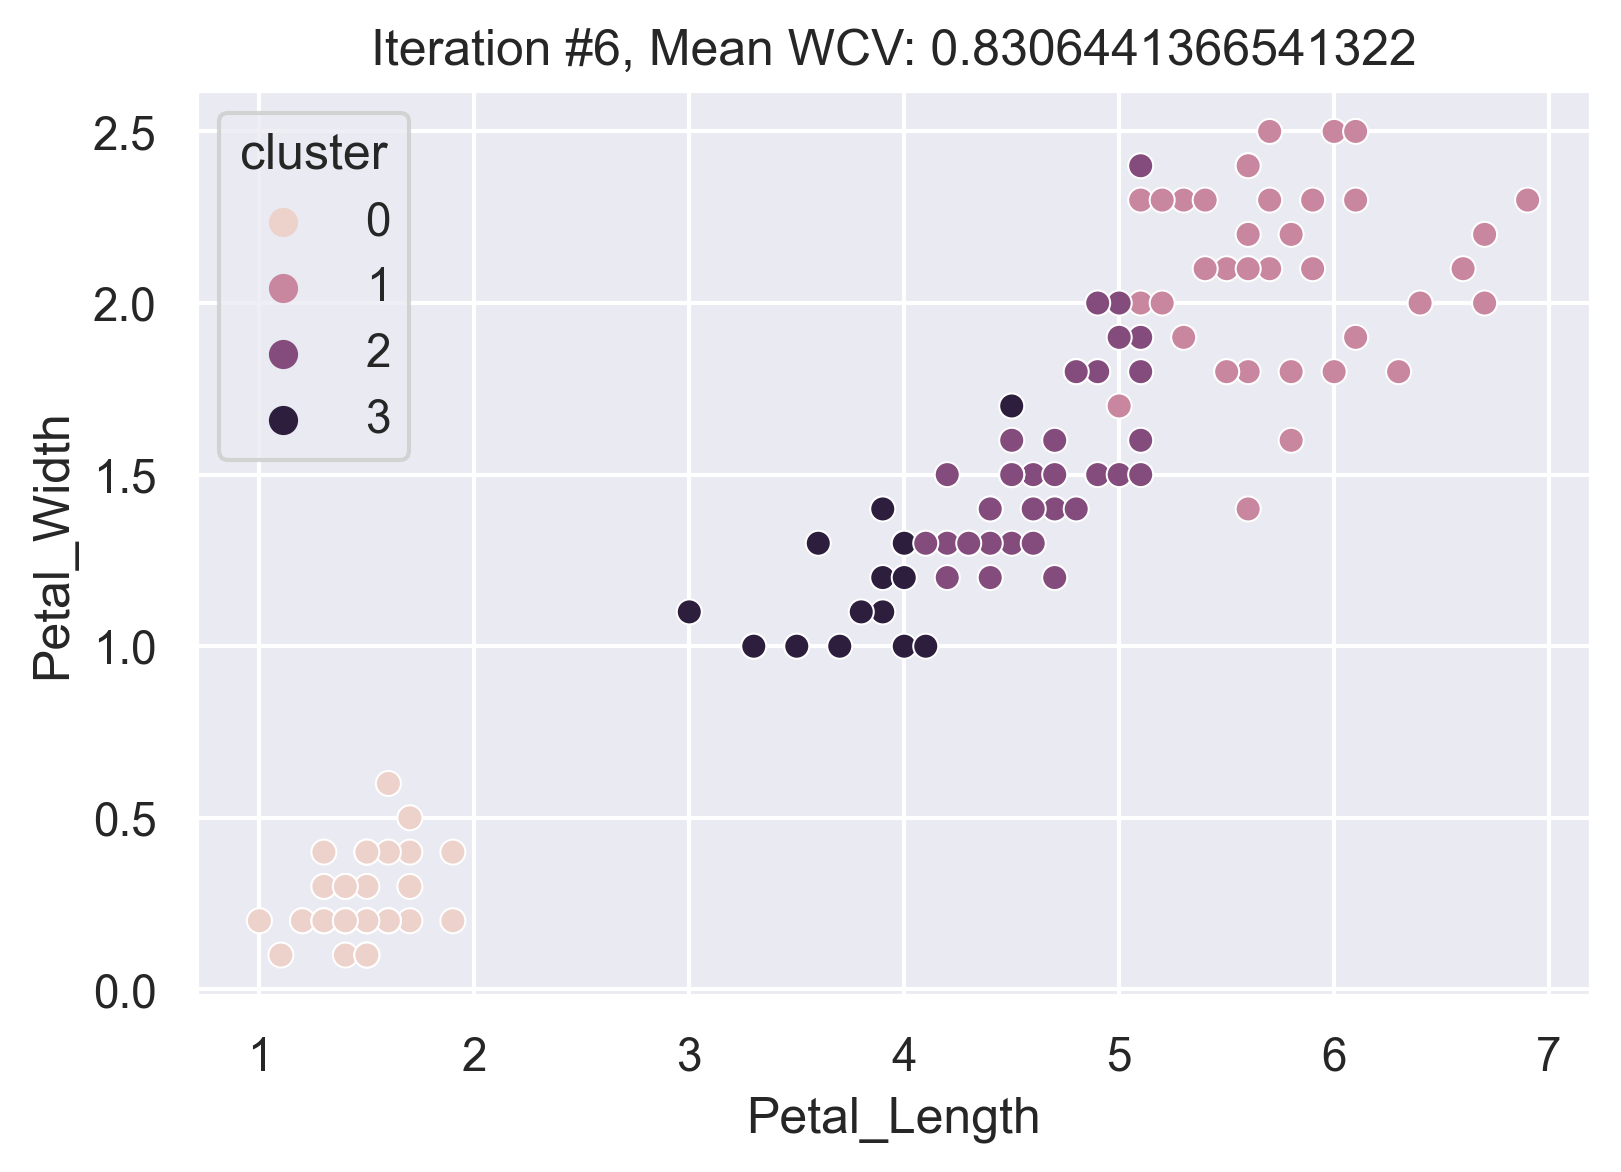

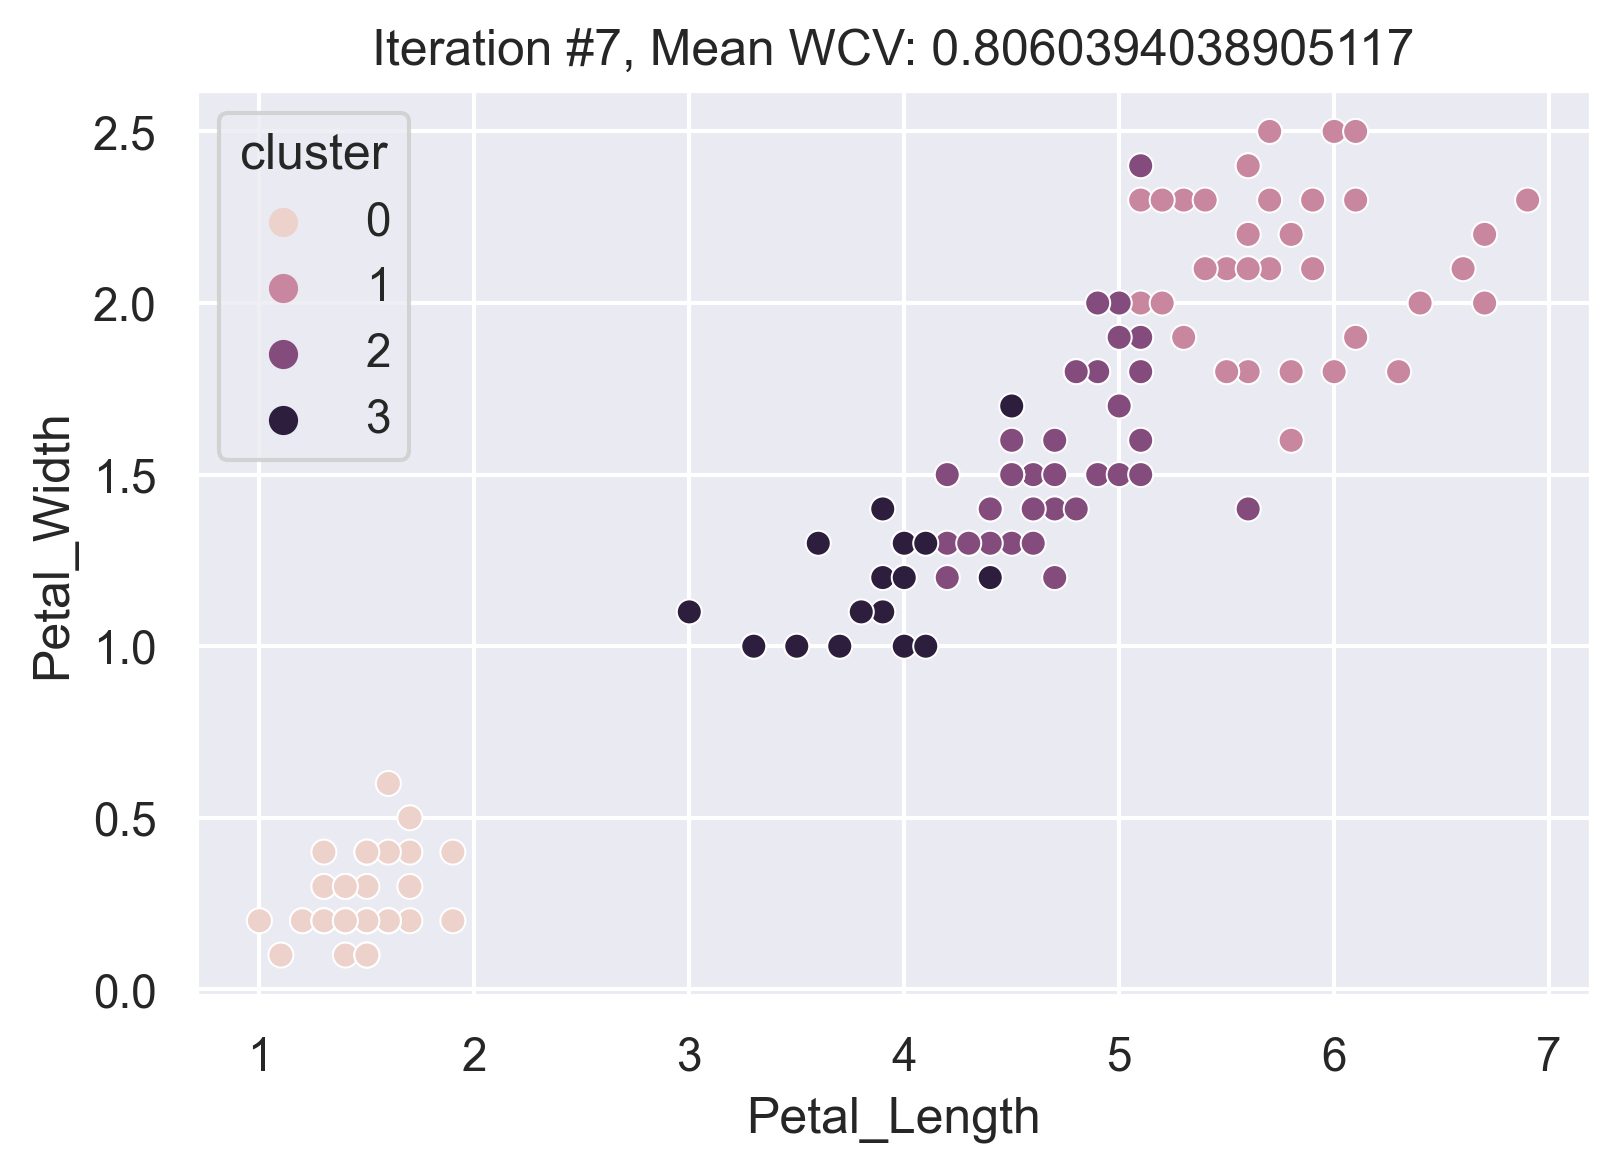

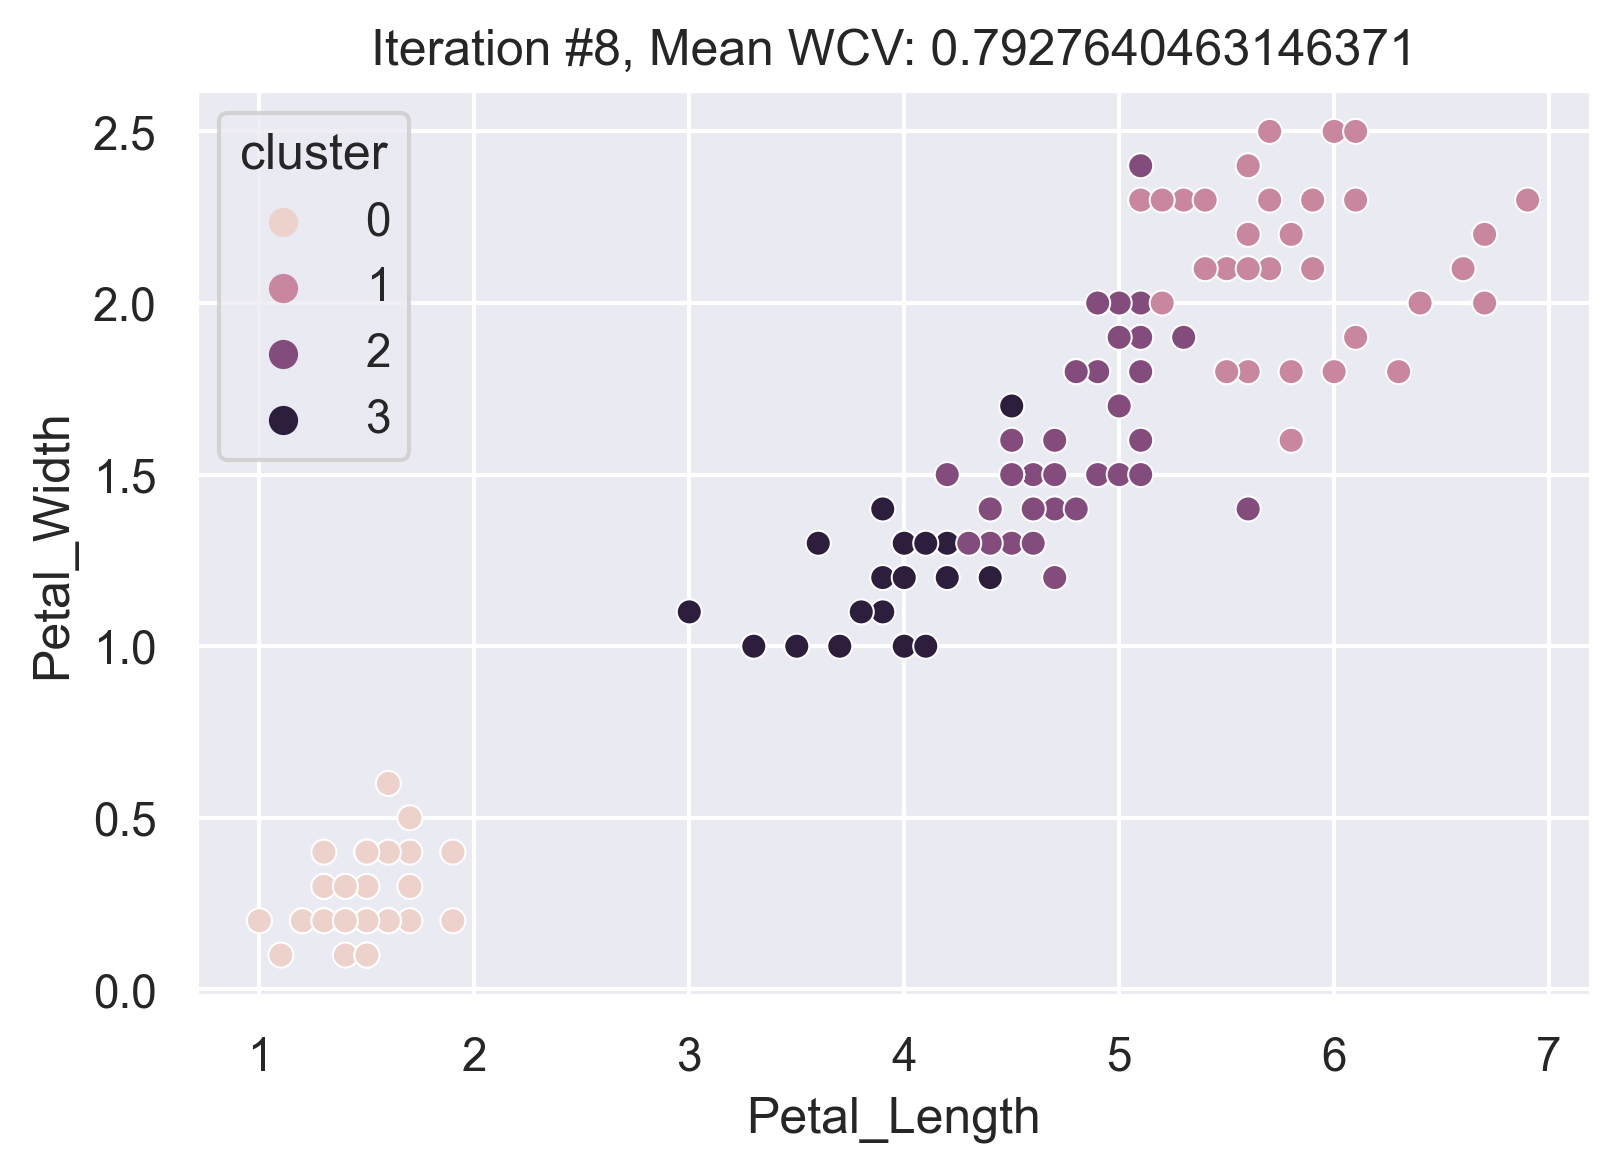

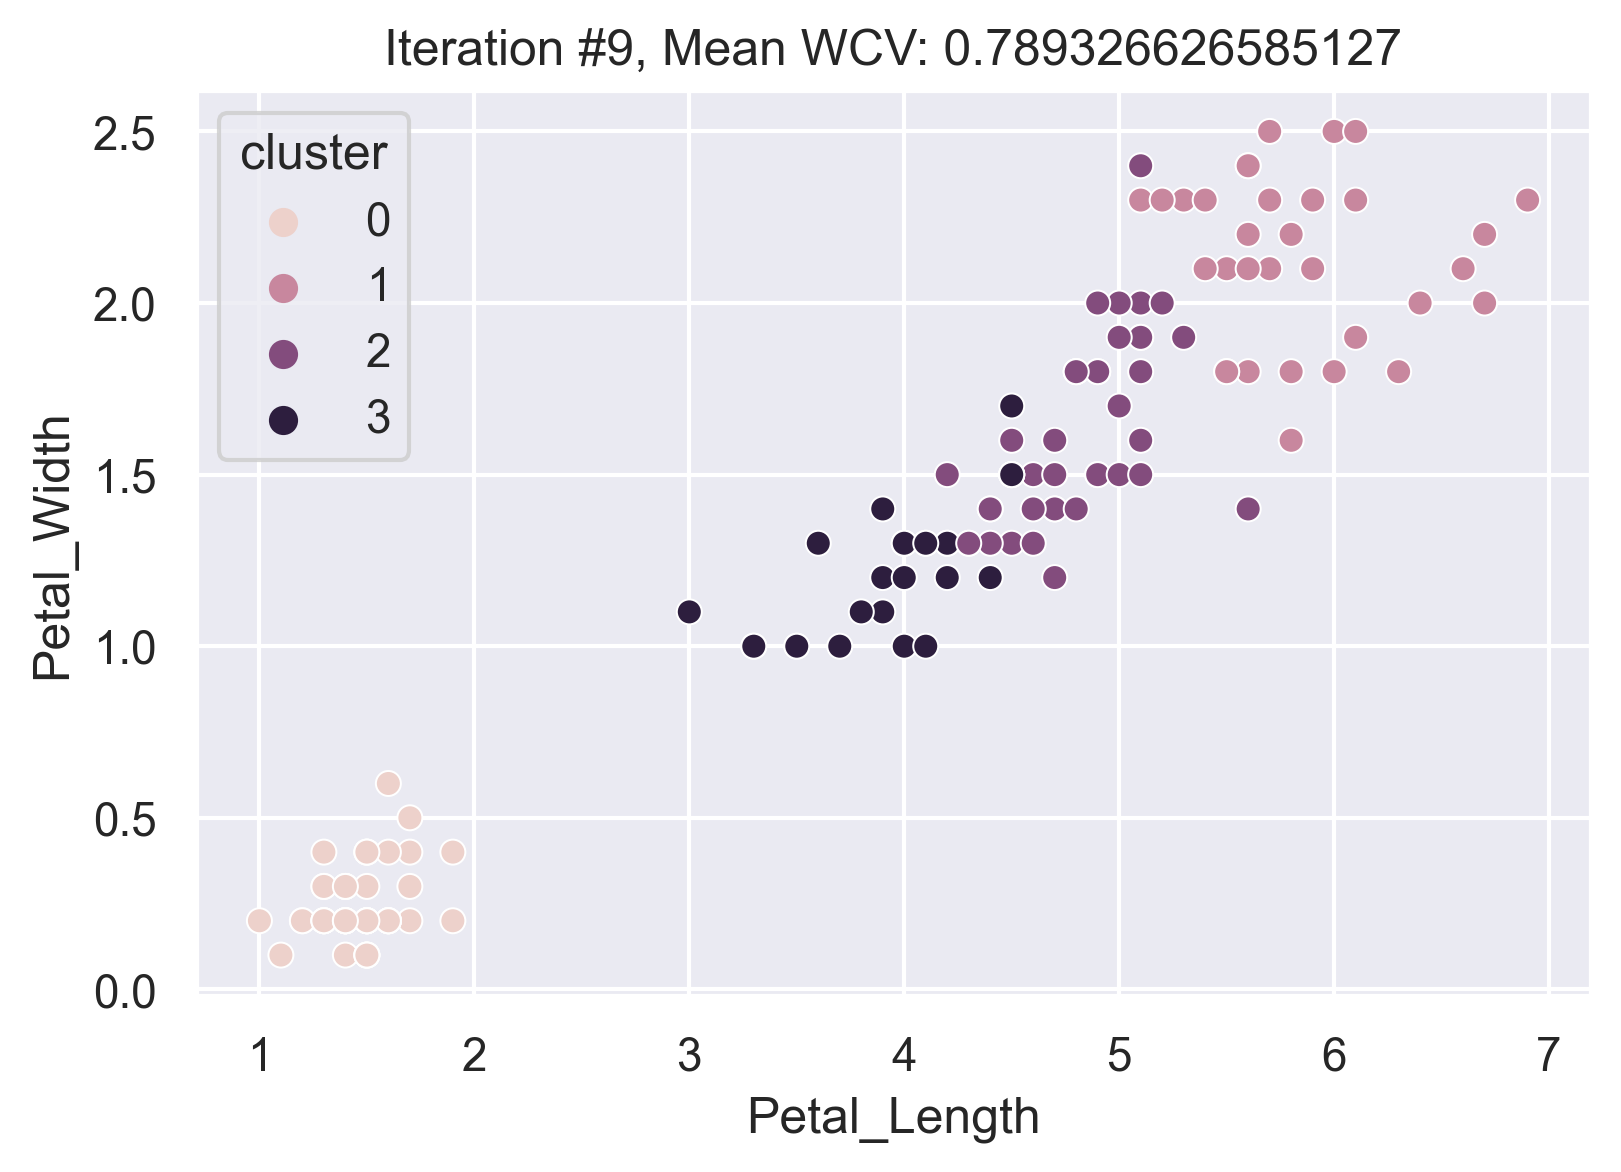

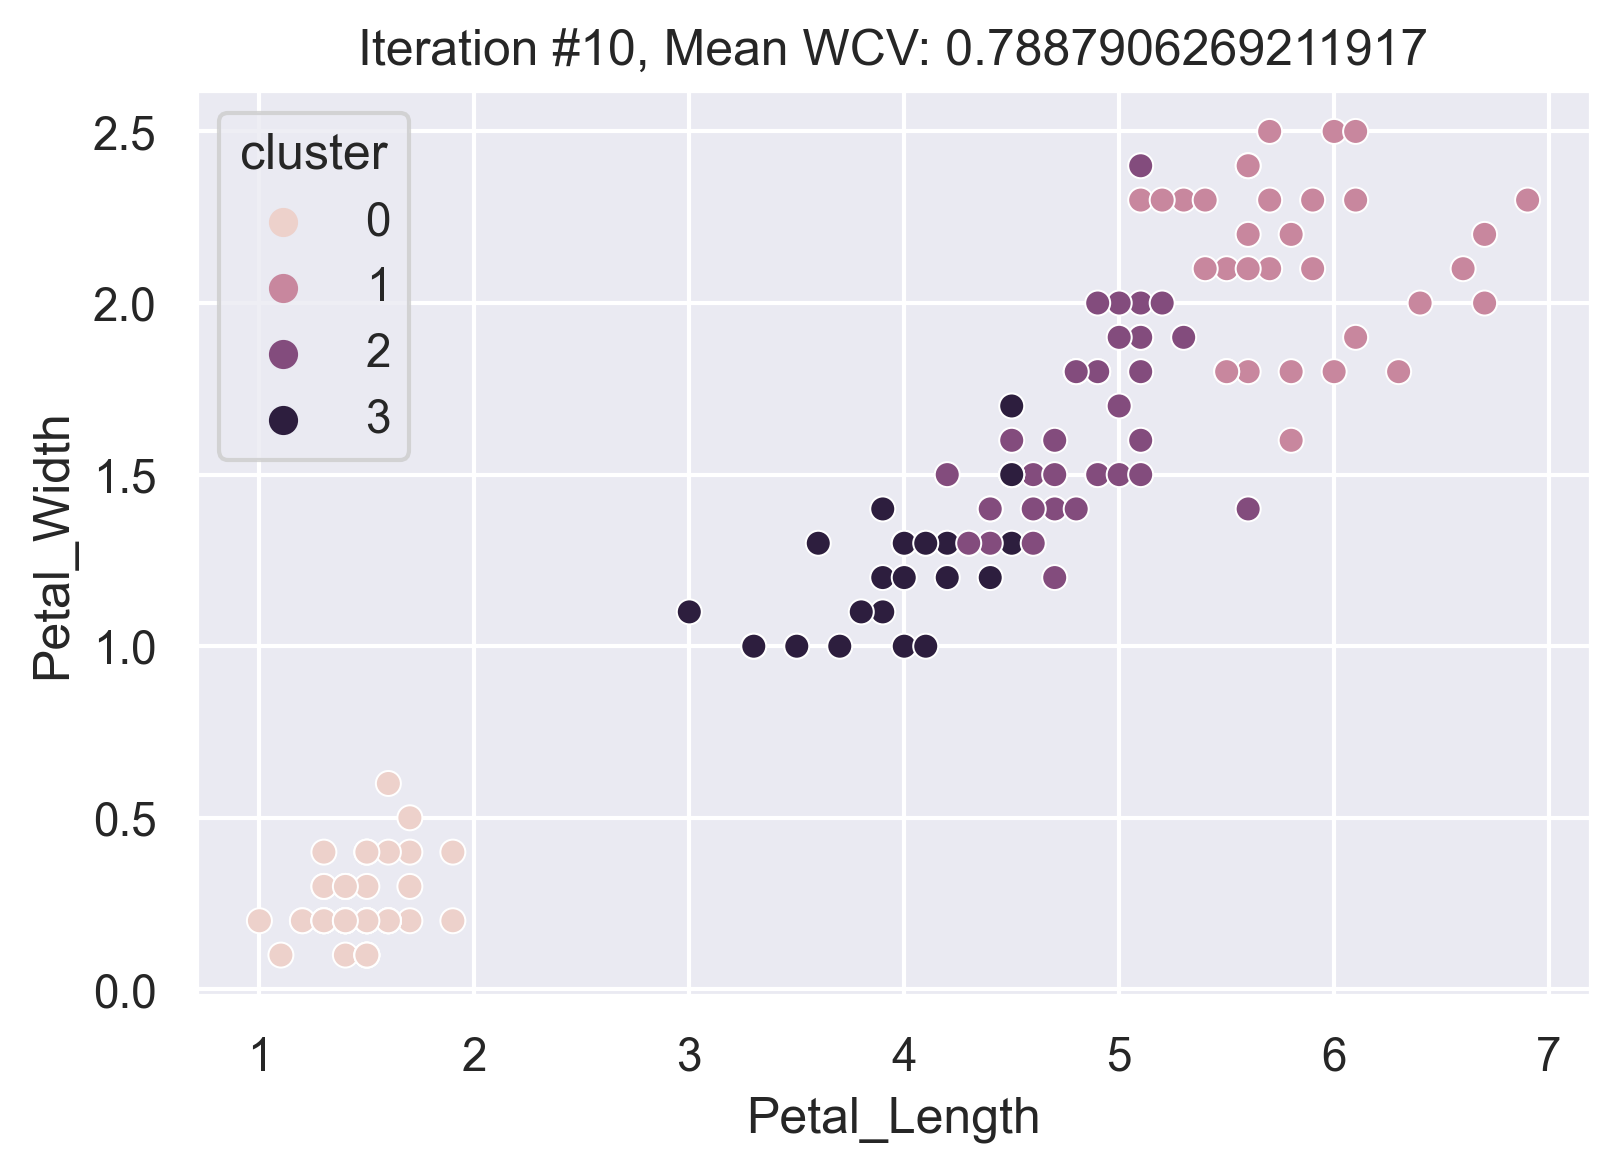

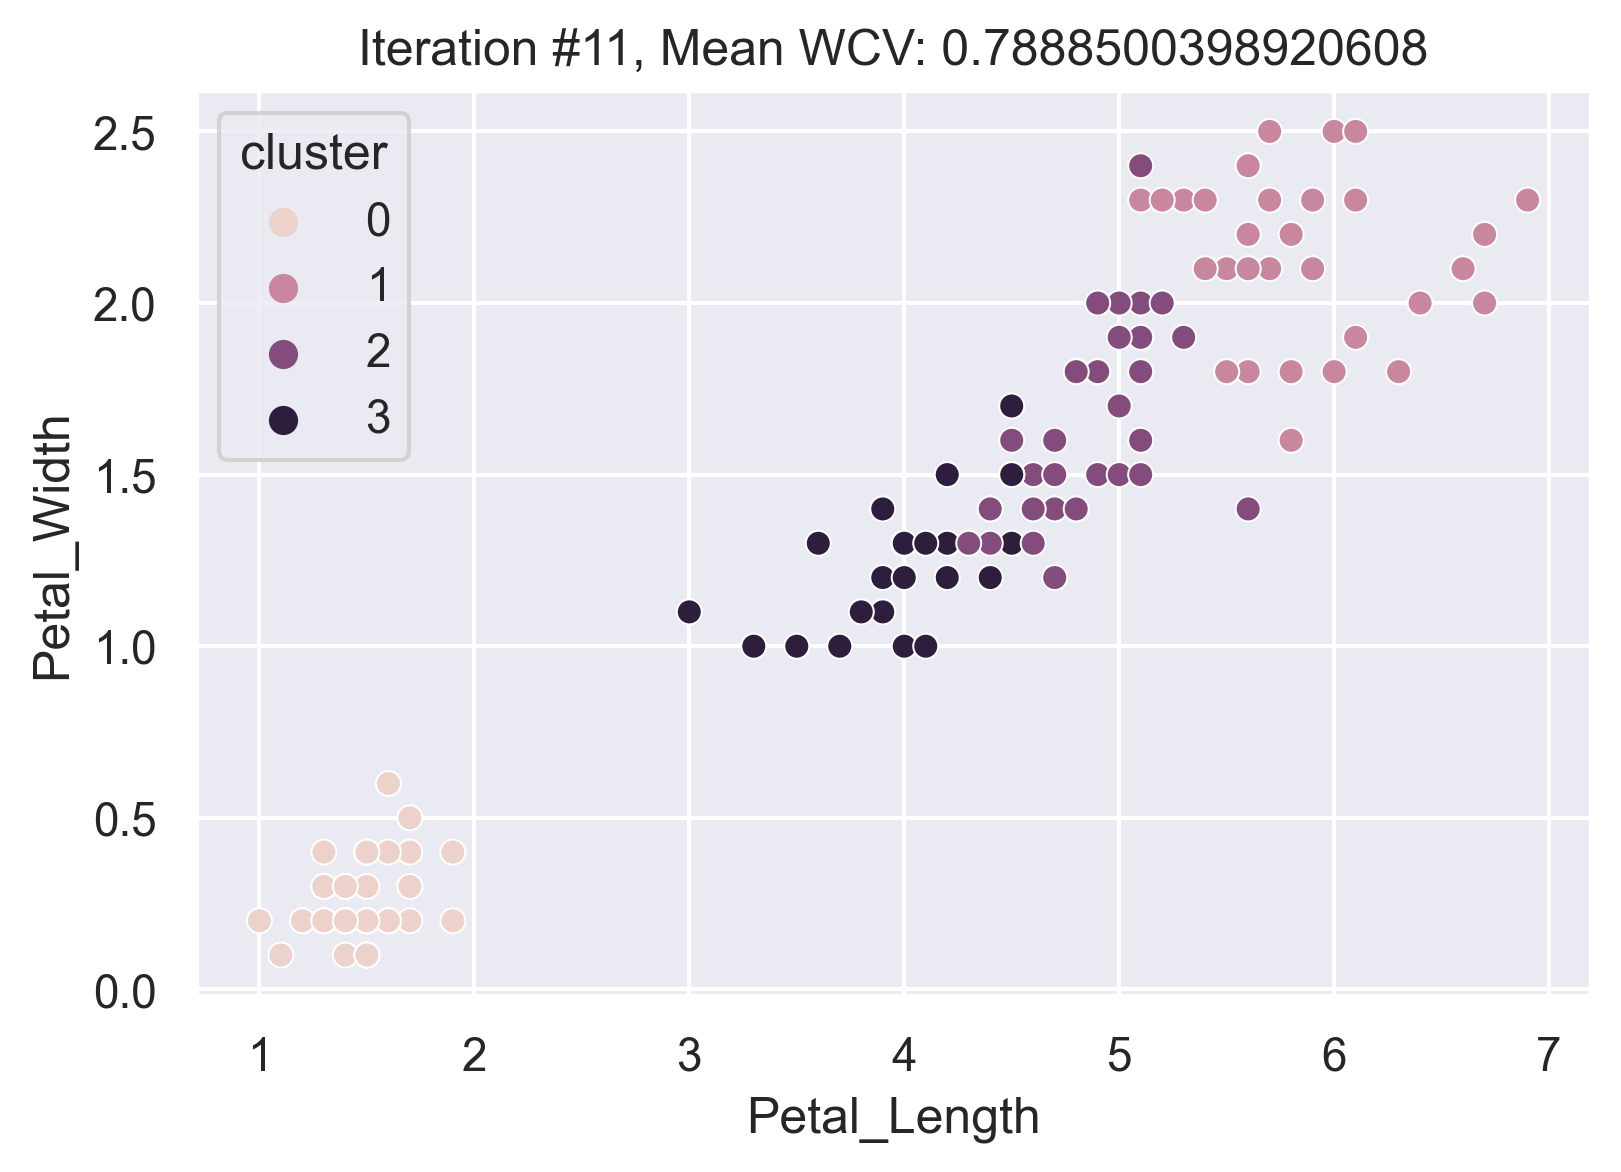

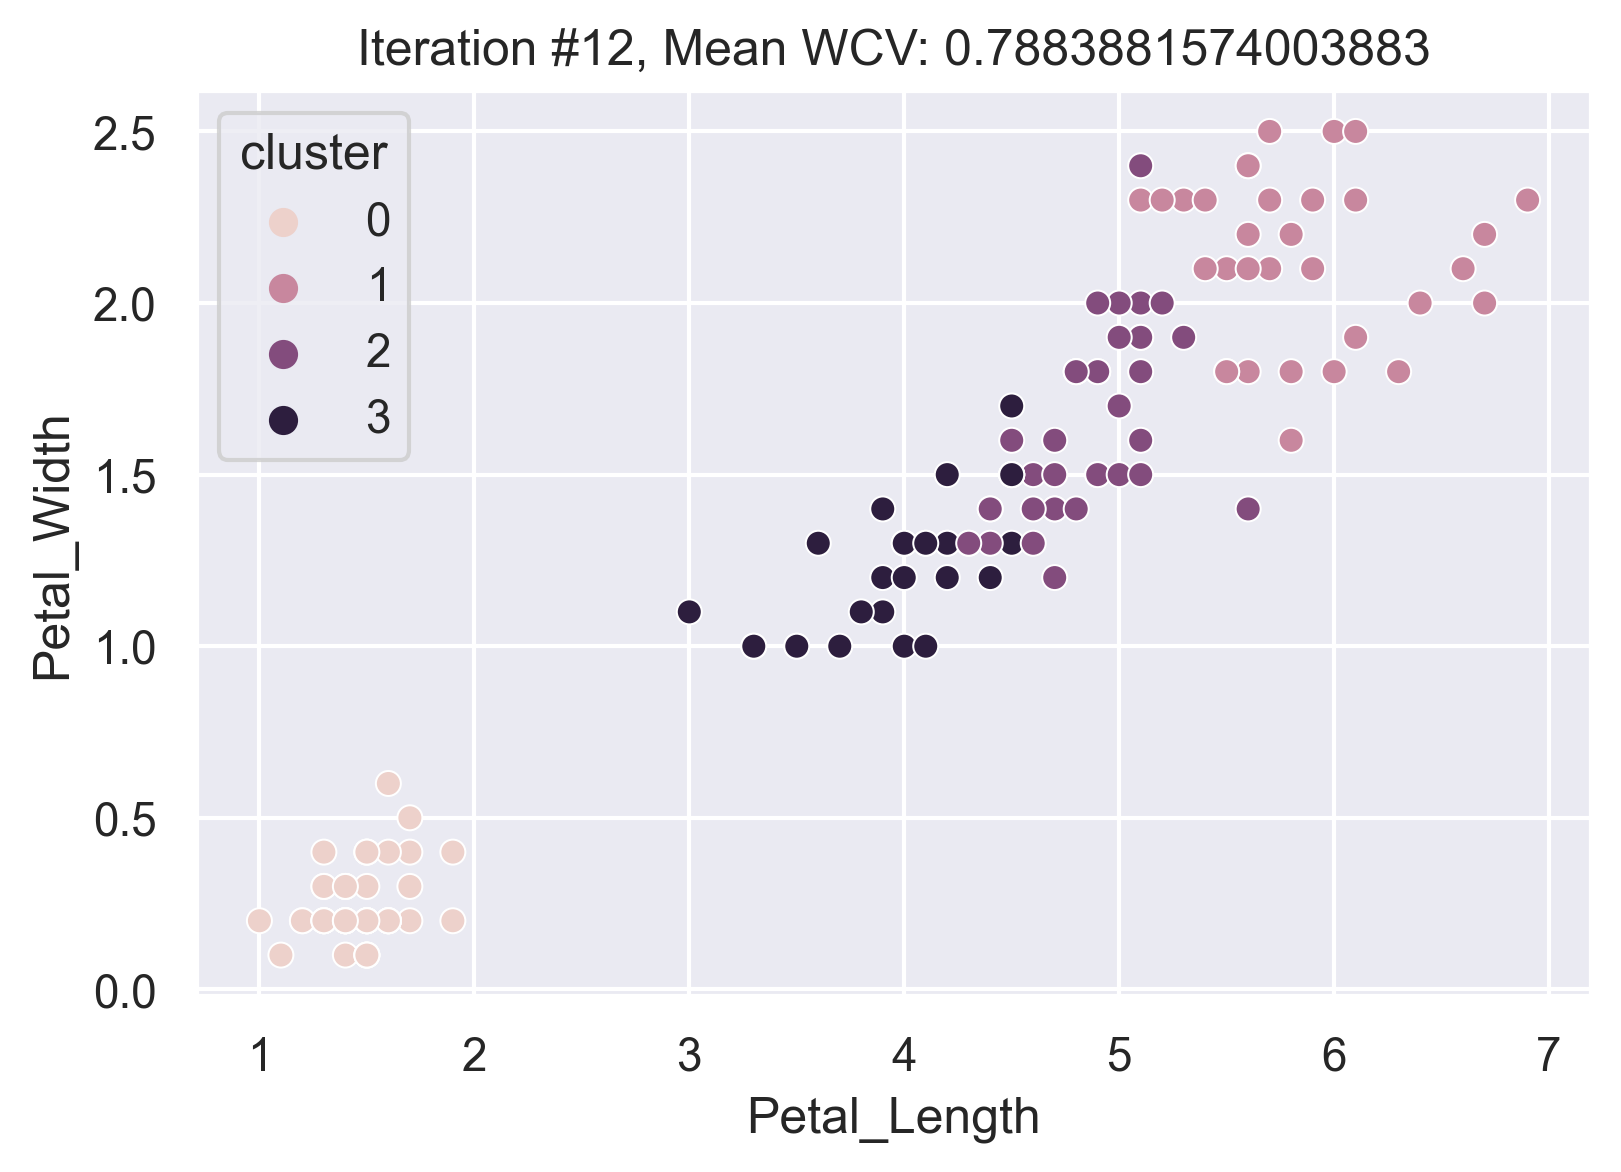

In [19]:
k_means = KMeans(df=iris, num_clusters=4)
k_means.fit(with_visualization=True)

Iteration #1, Mean WCV: 5.060769876675965
Iteration #2, Mean WCV: 1.1813228353469805
Iteration #3, Mean WCV: 1.0685914510239563
Iteration #4, Mean WCV: 1.061558327976566
Iteration #5, Mean WCV: 1.0841971944428497
Iteration #6, Mean WCV: 1.0966156813108532
Iteration #7, Mean WCV: 1.0911866942363495
Iteration #8, Mean WCV: 1.0863649082125604
Iteration #9, Mean WCV: 1.0762799645991192
Iteration #10, Mean WCV: 1.0678863639487362
Iteration #11, Mean WCV: 1.0570797074868057
Iteration #12, Mean WCV: 1.056108957432459


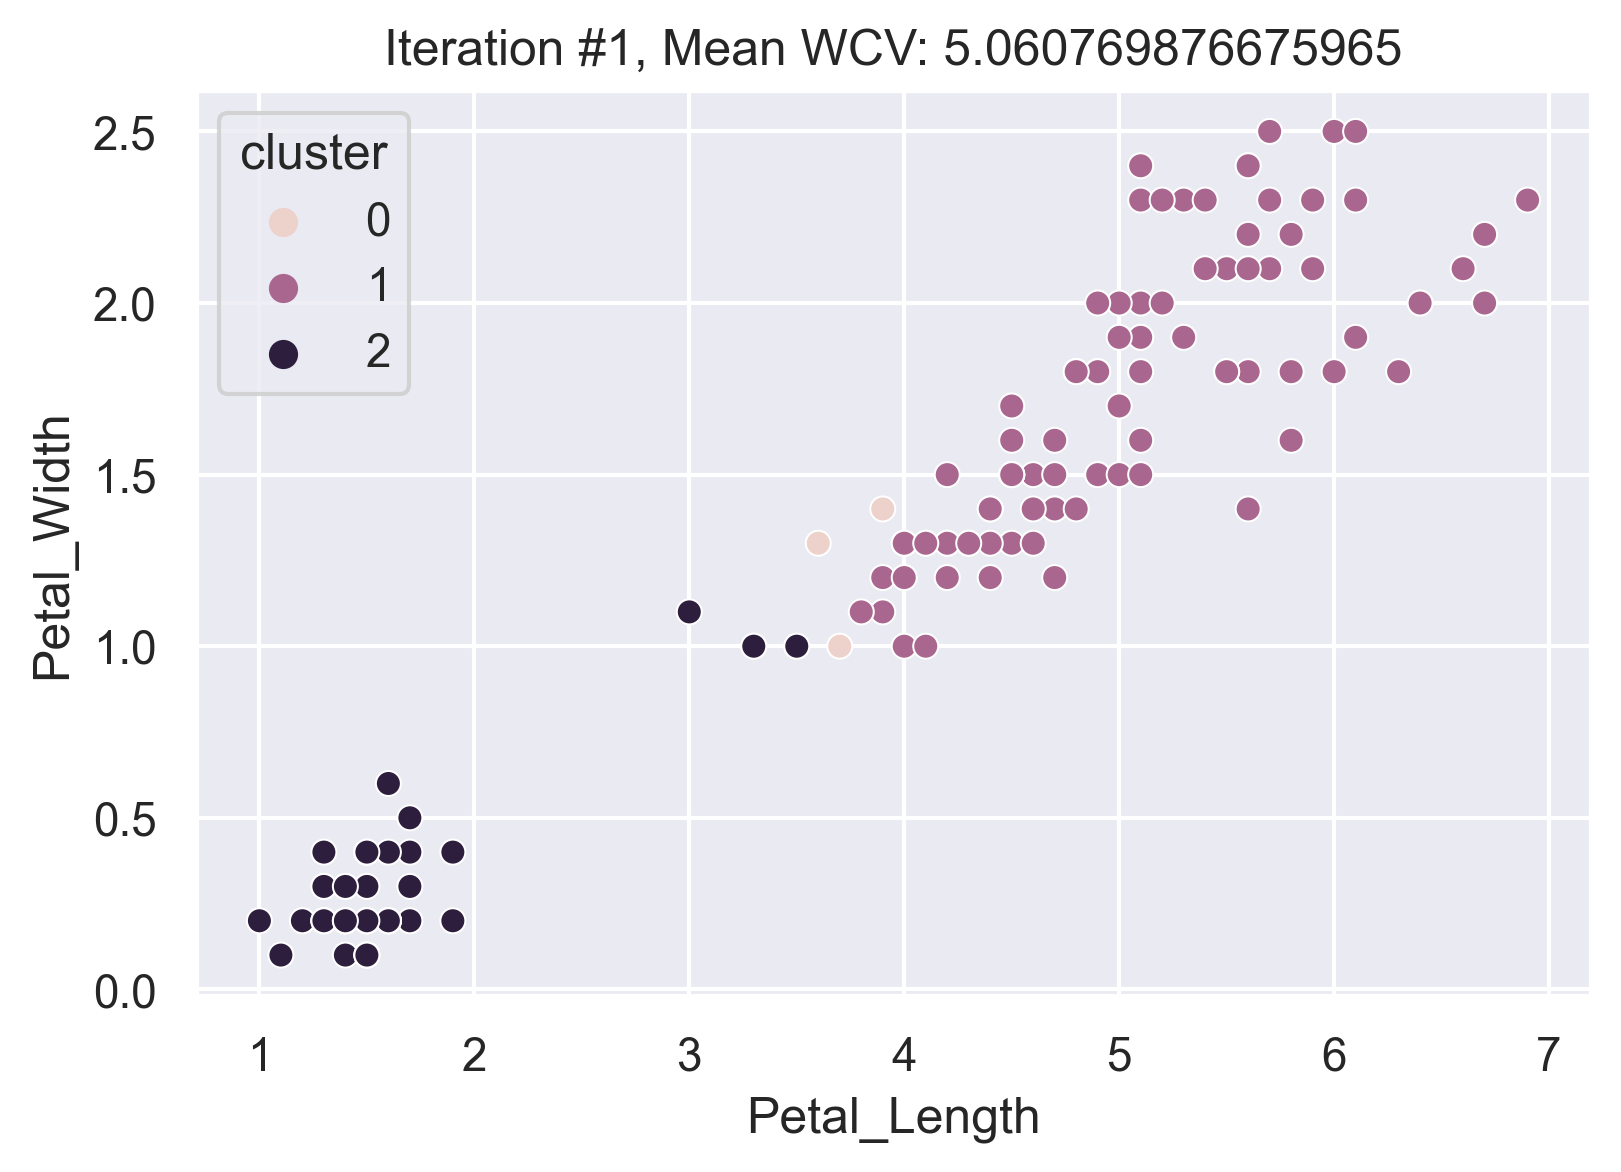

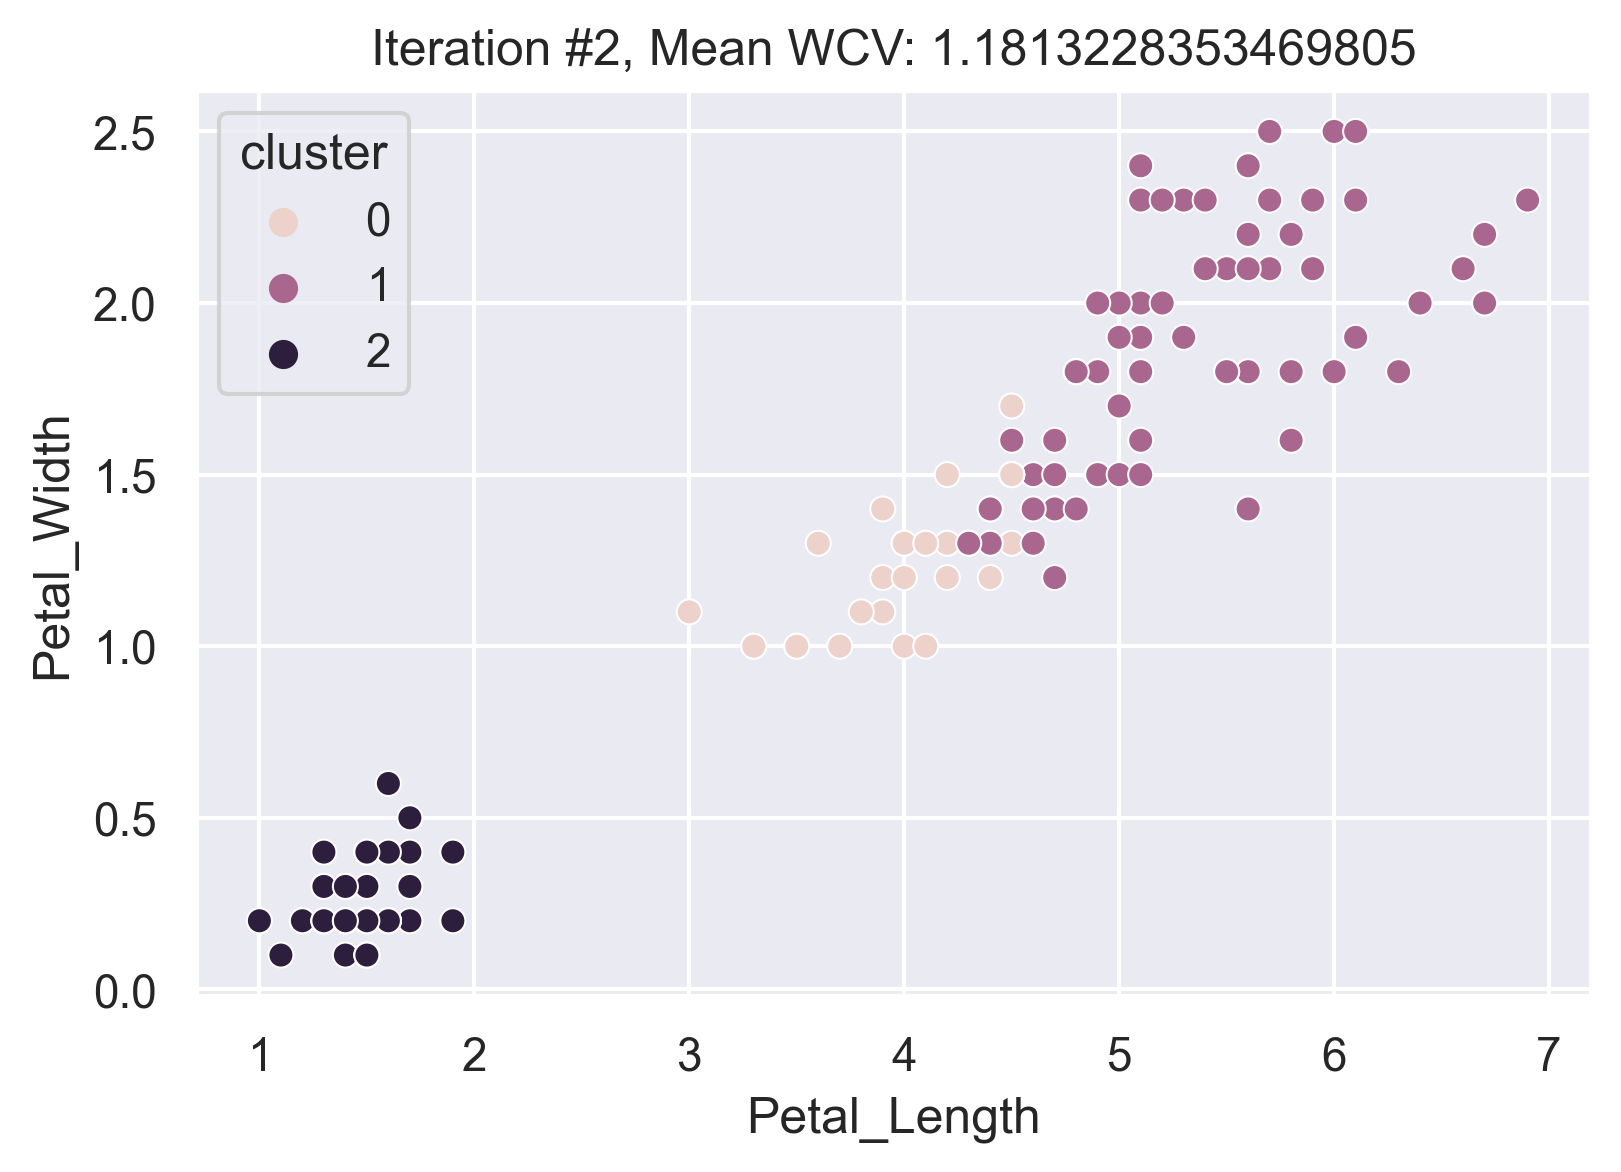

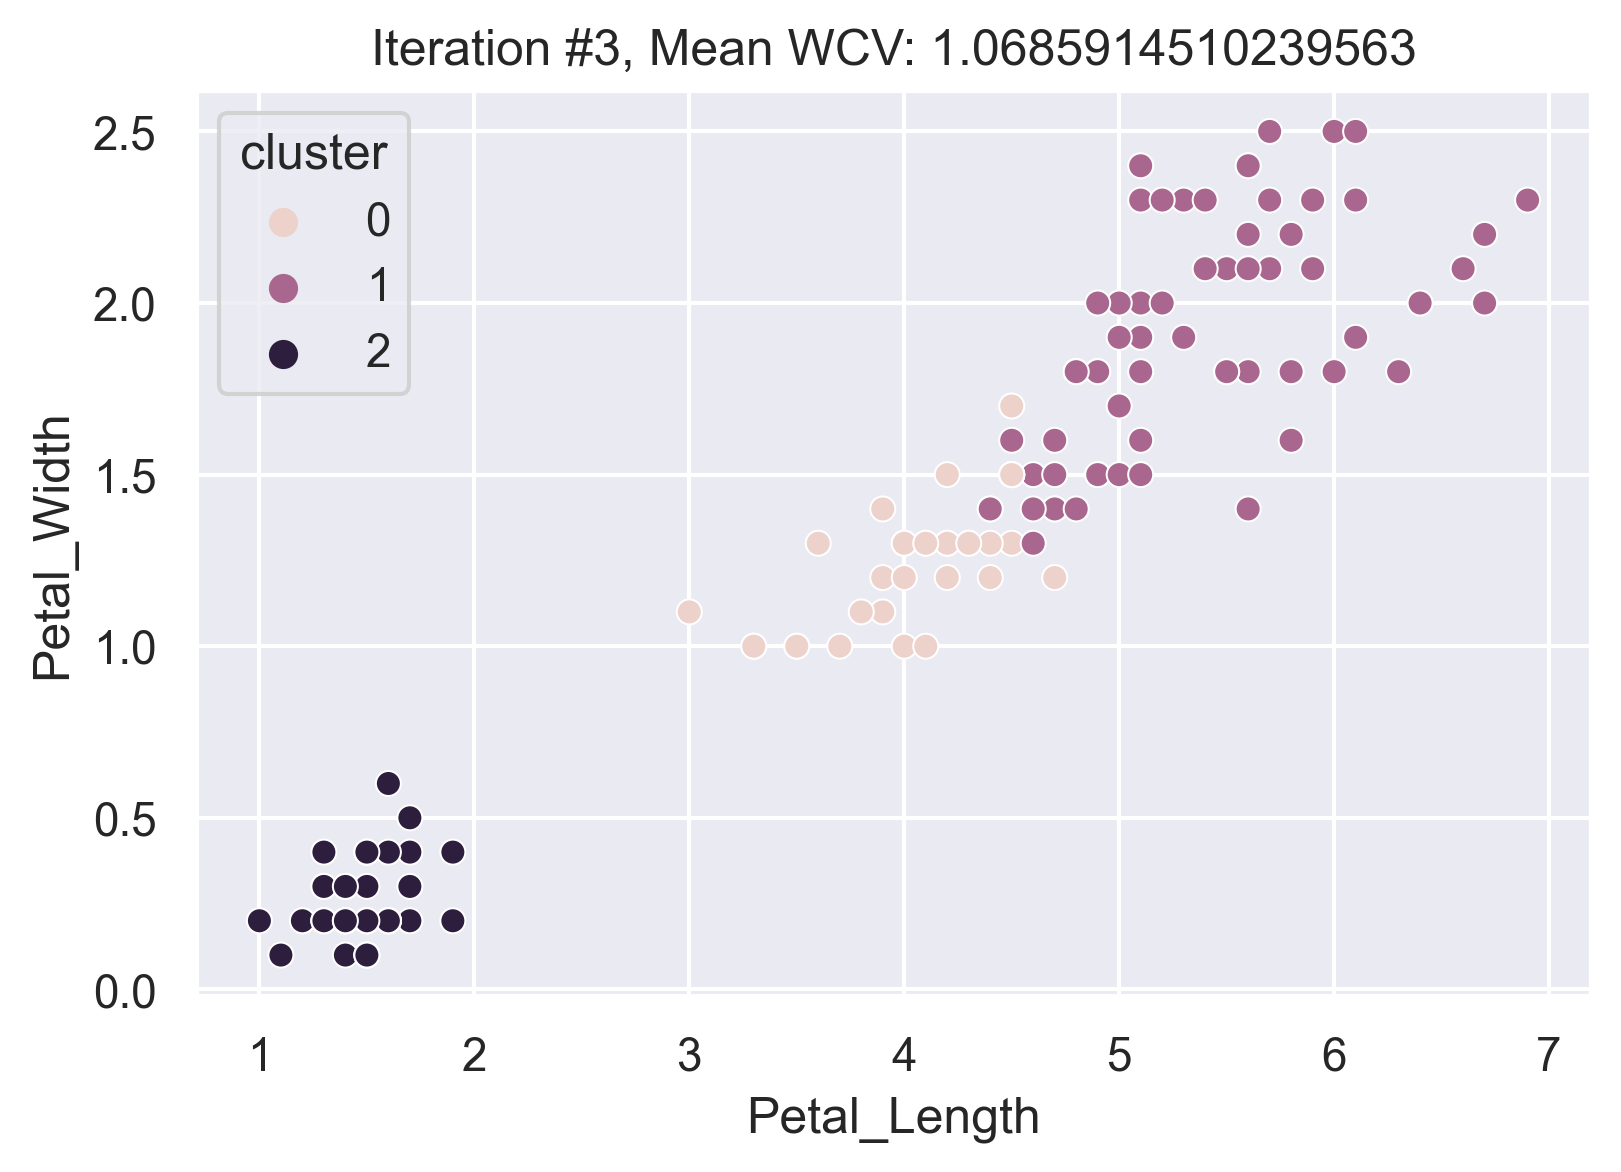

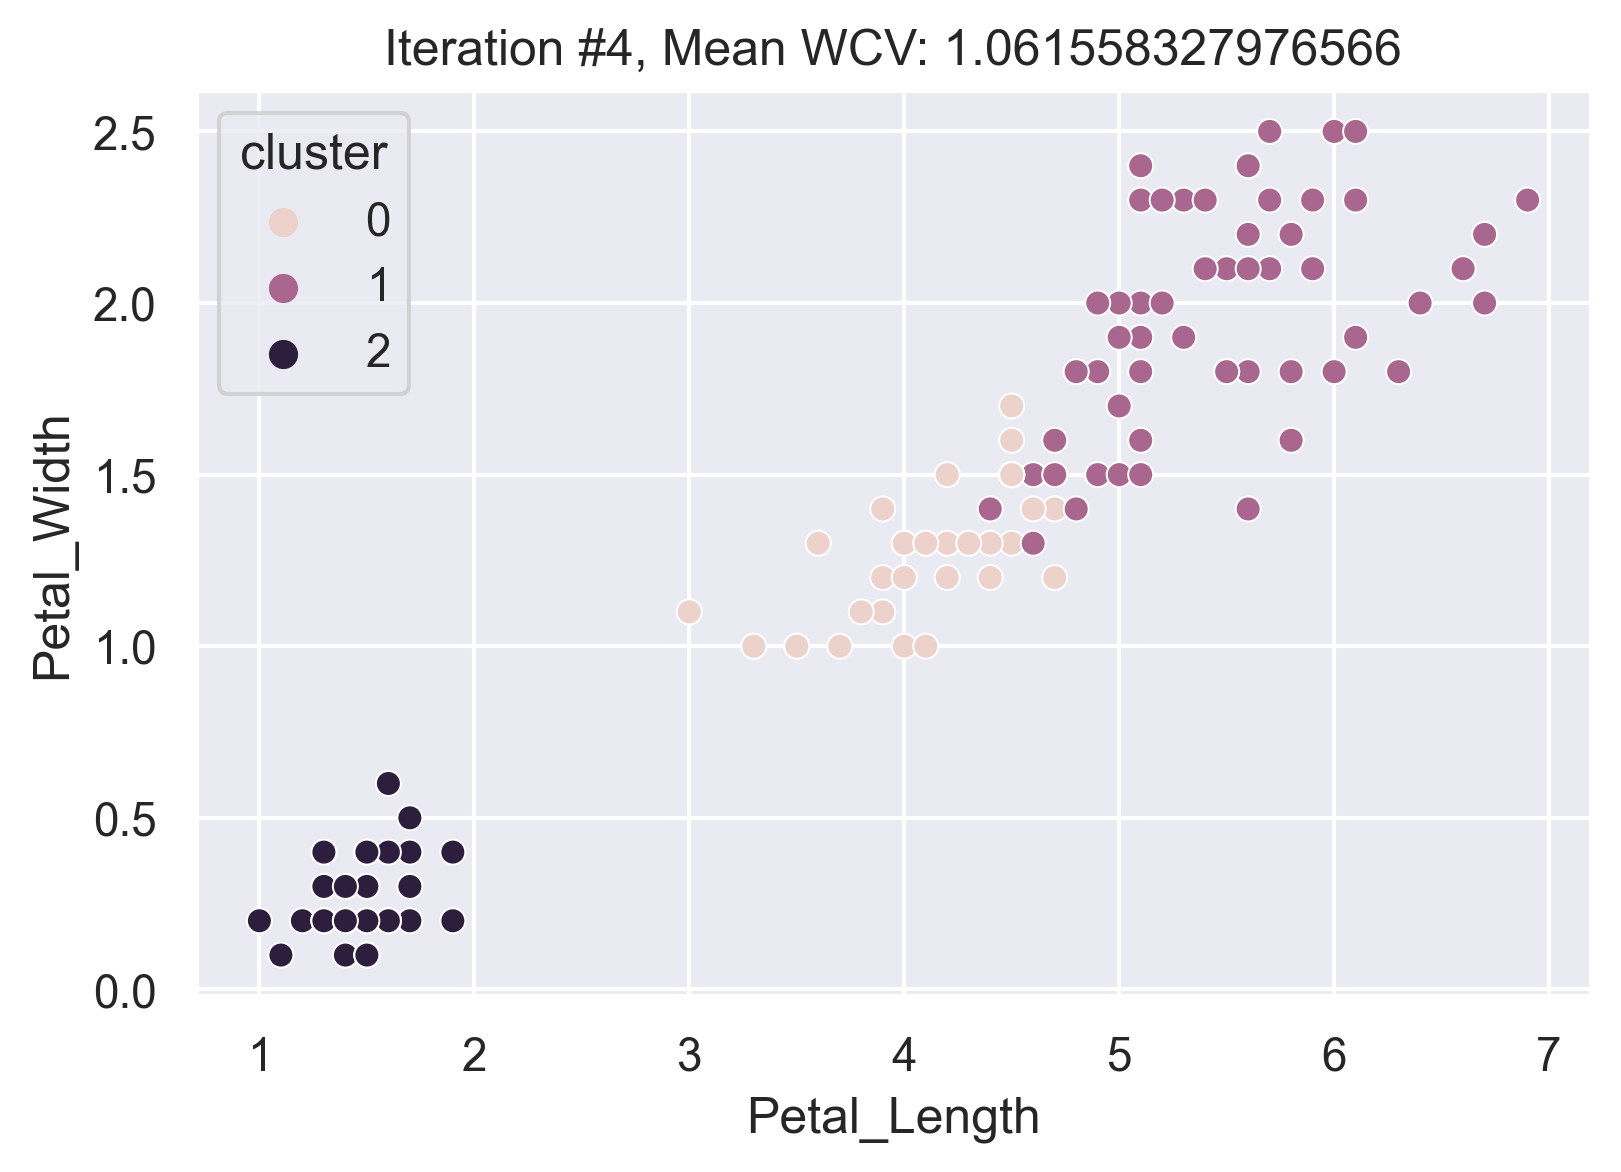

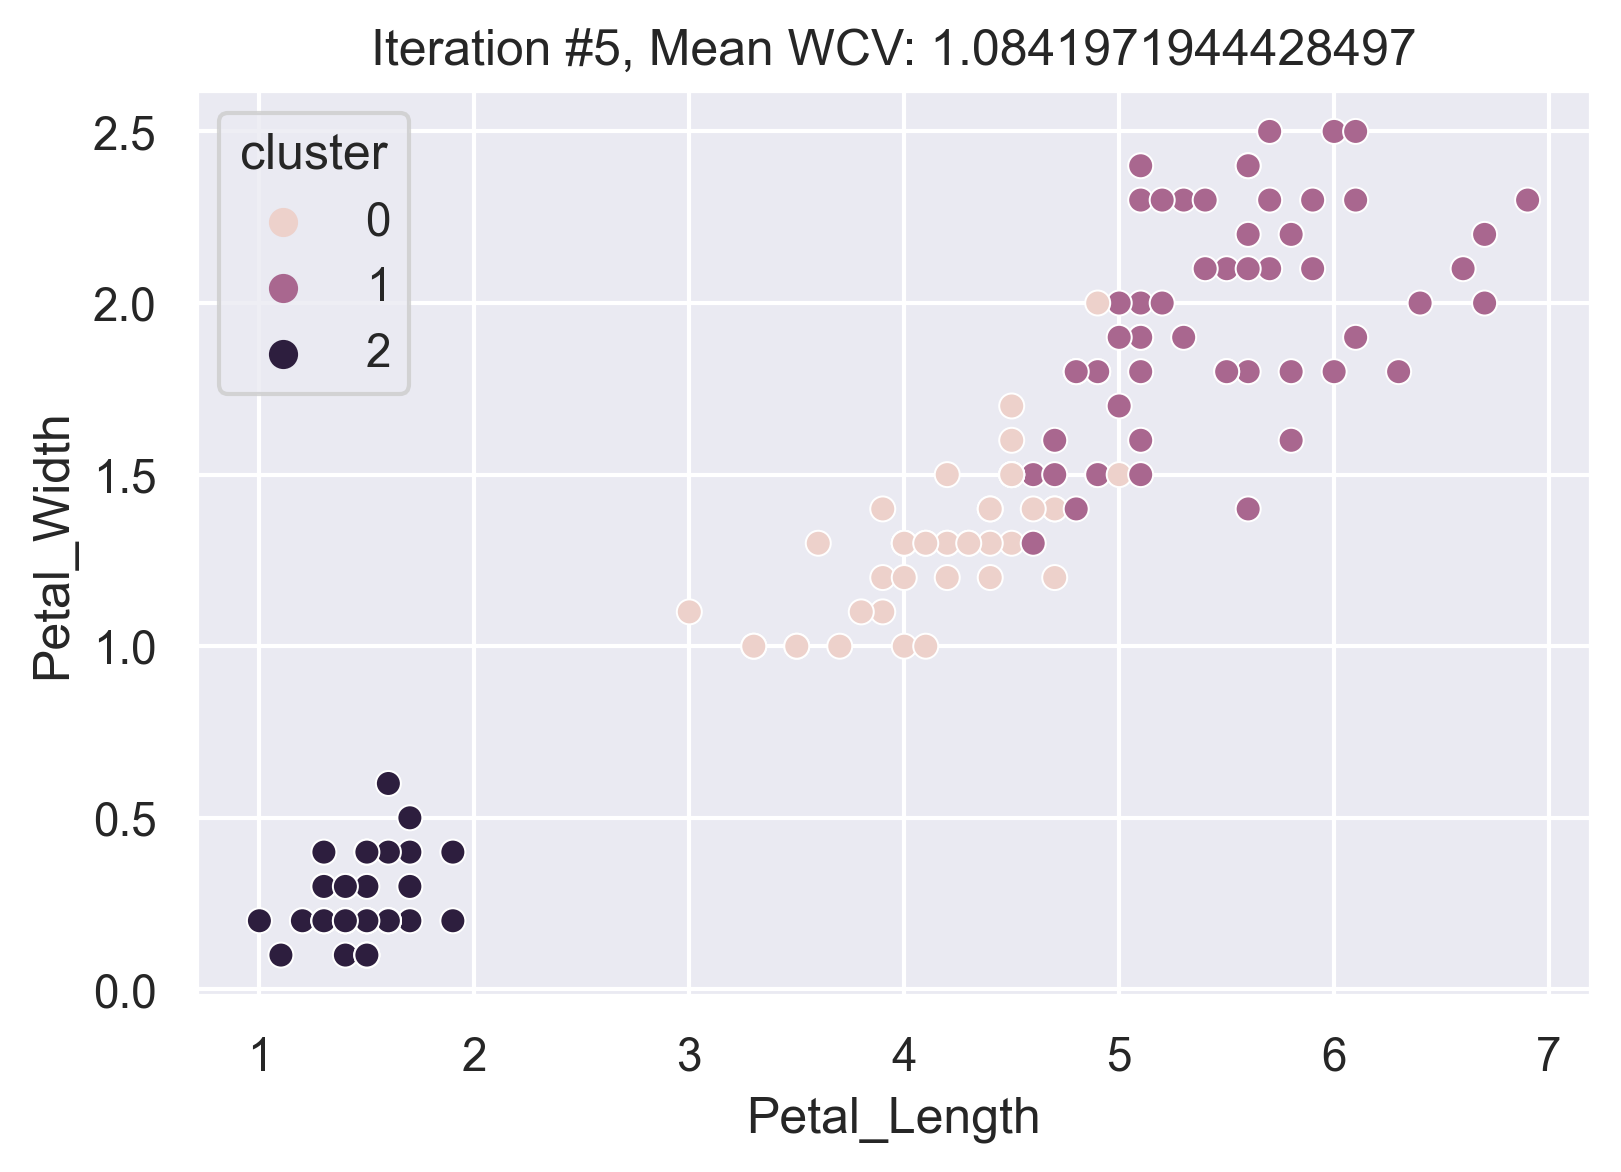

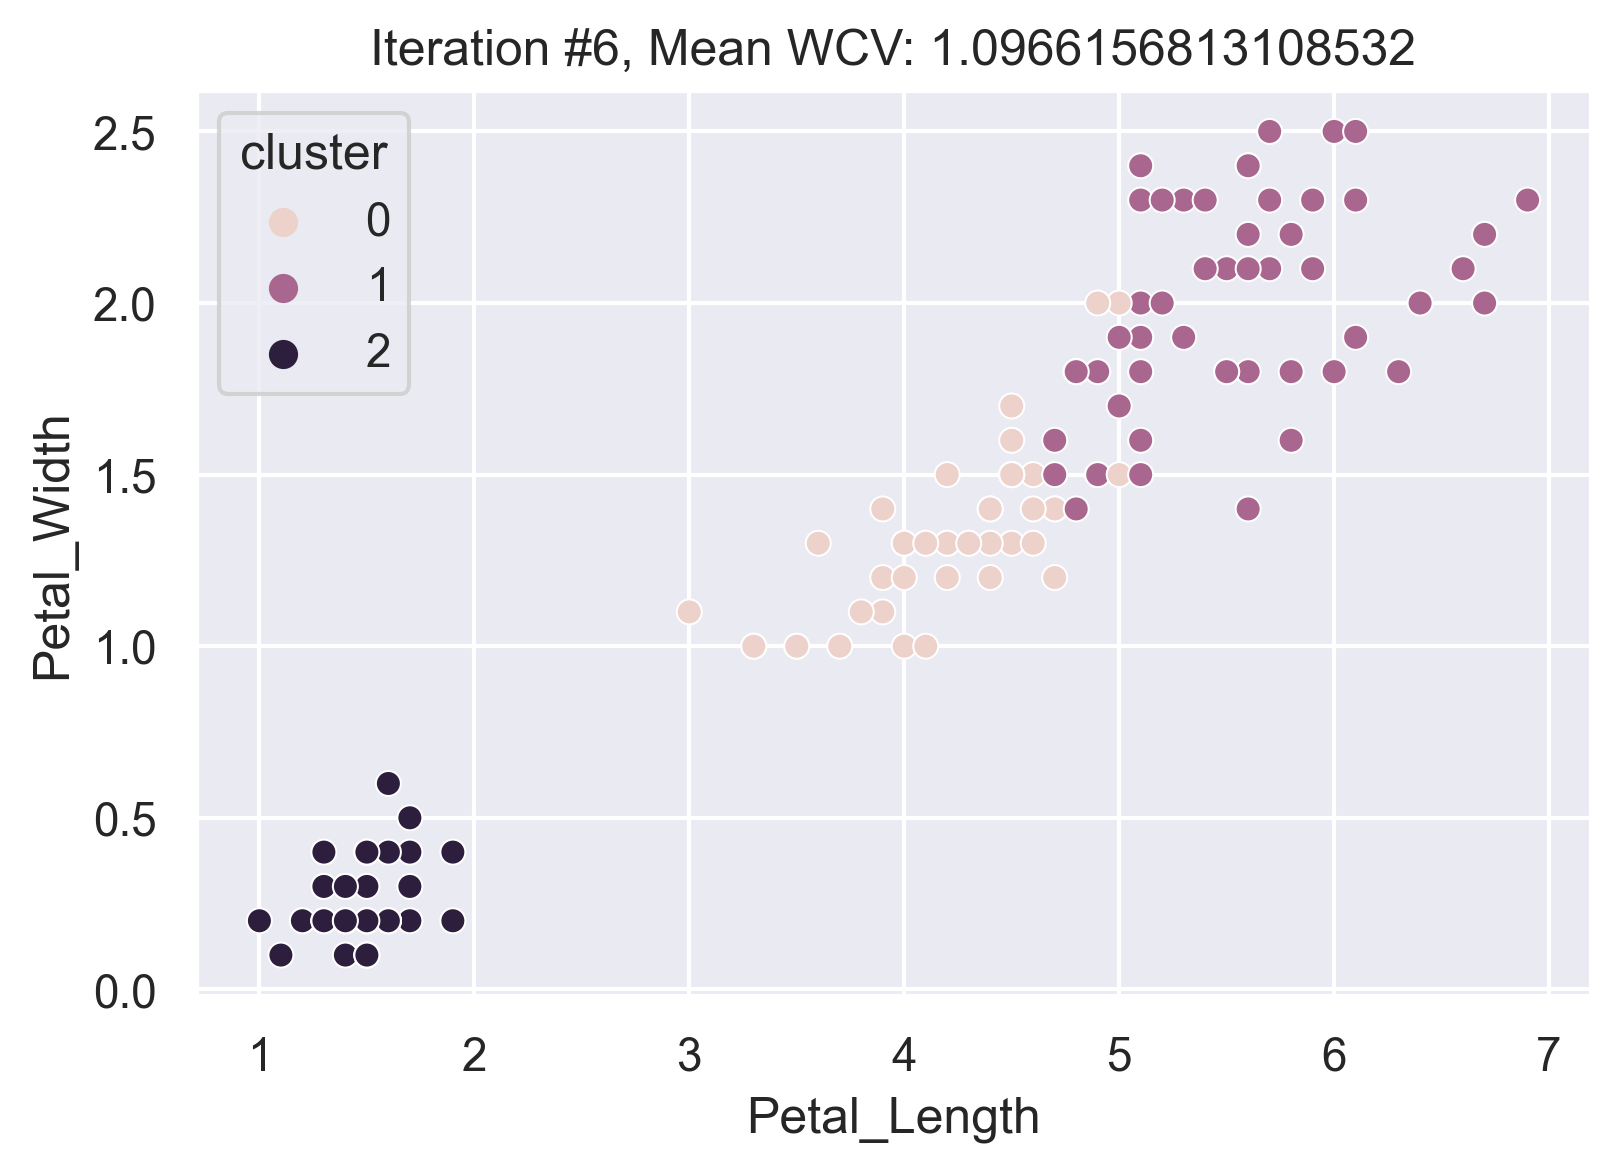

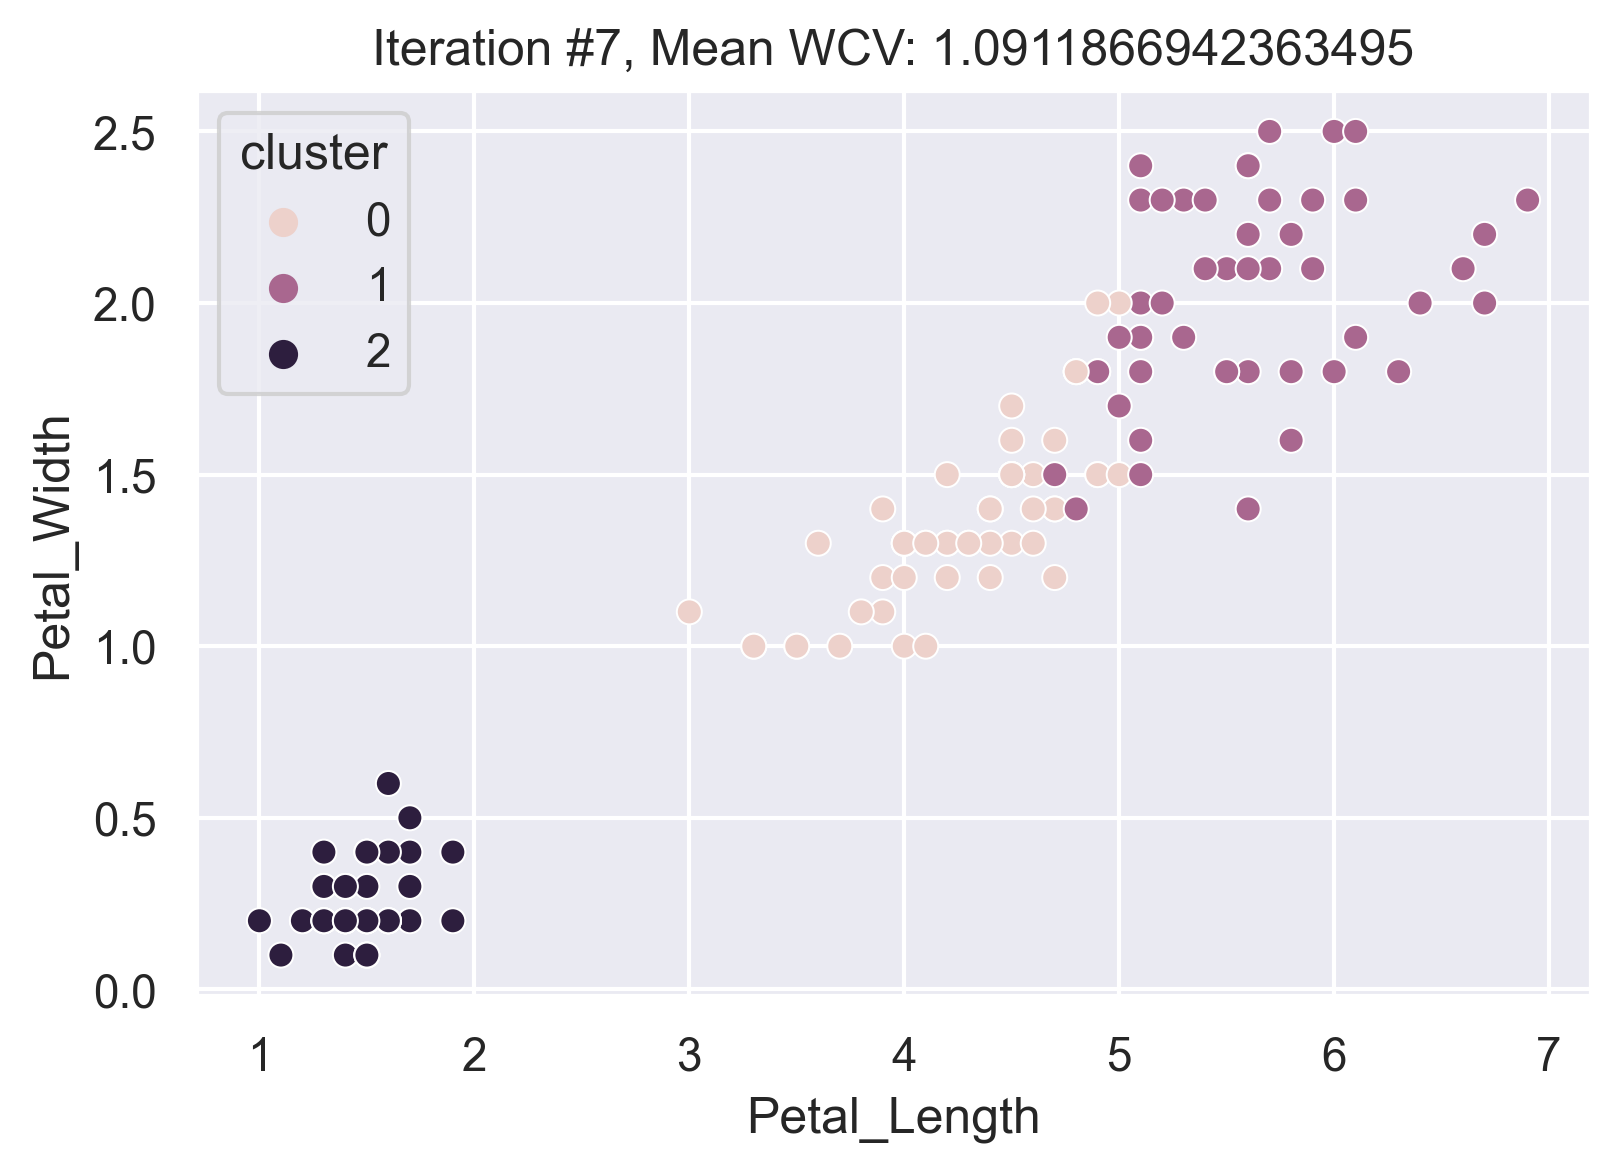

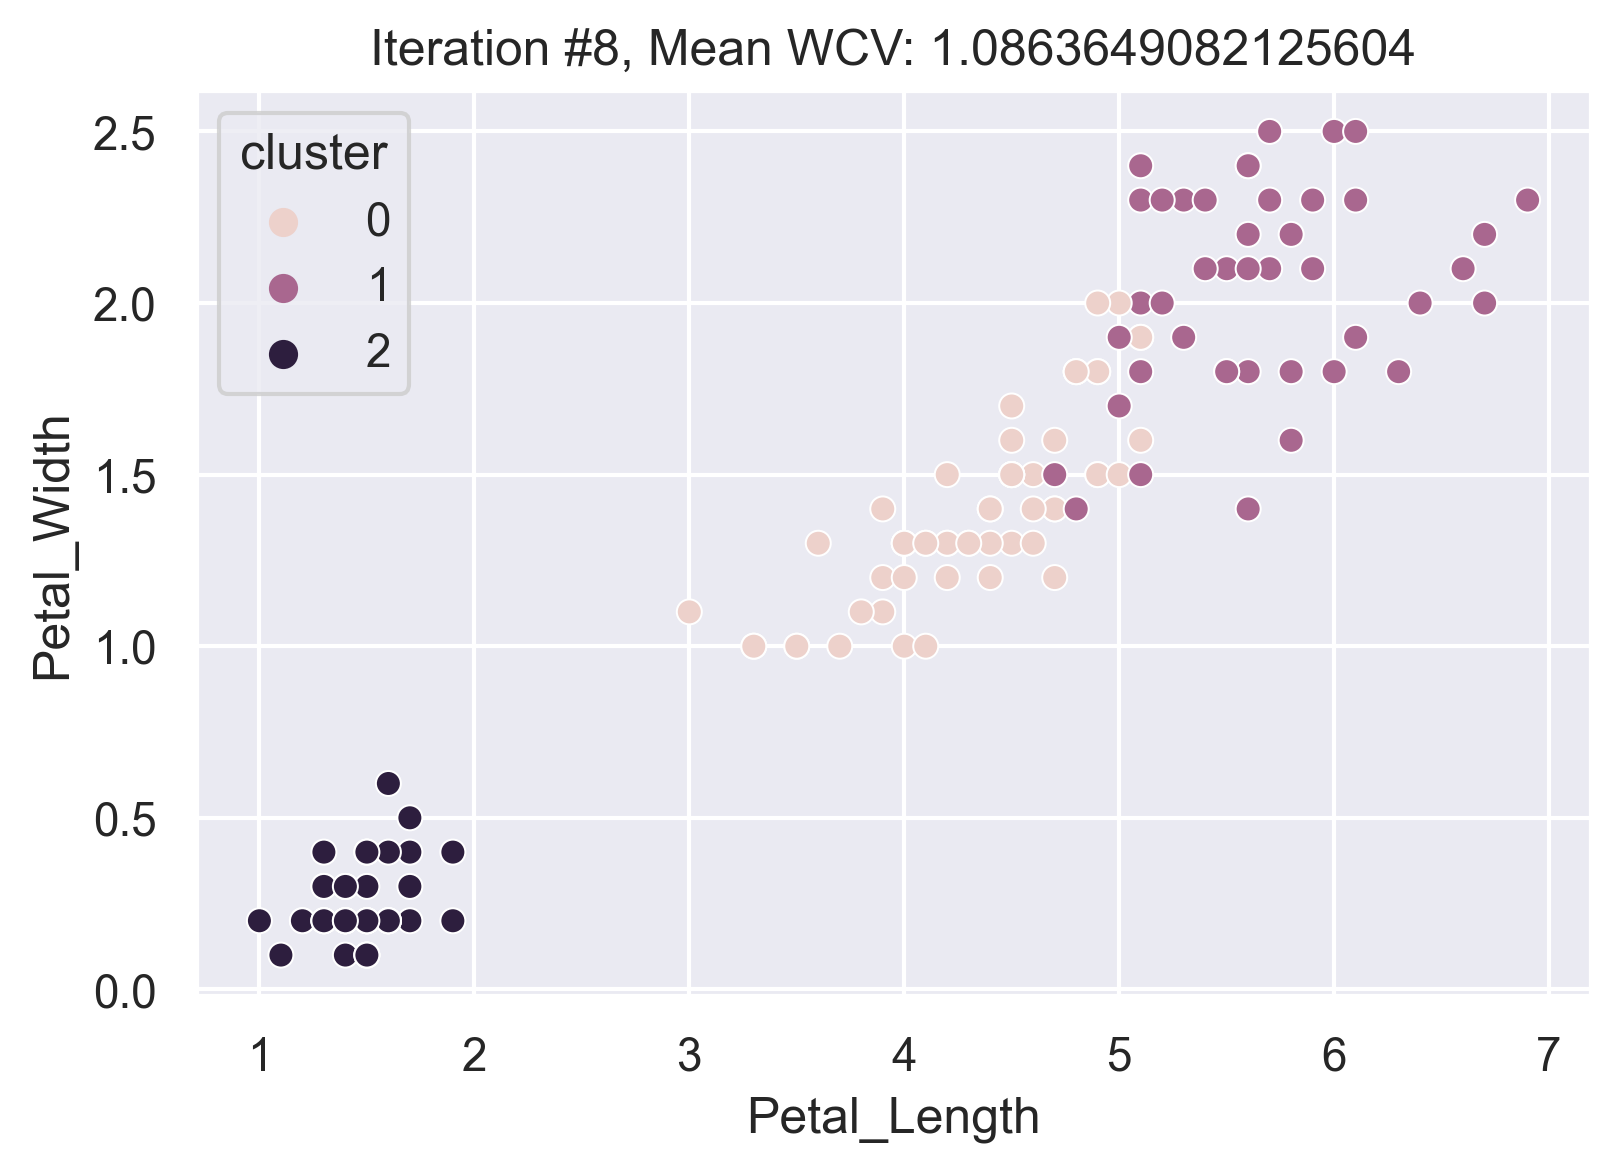

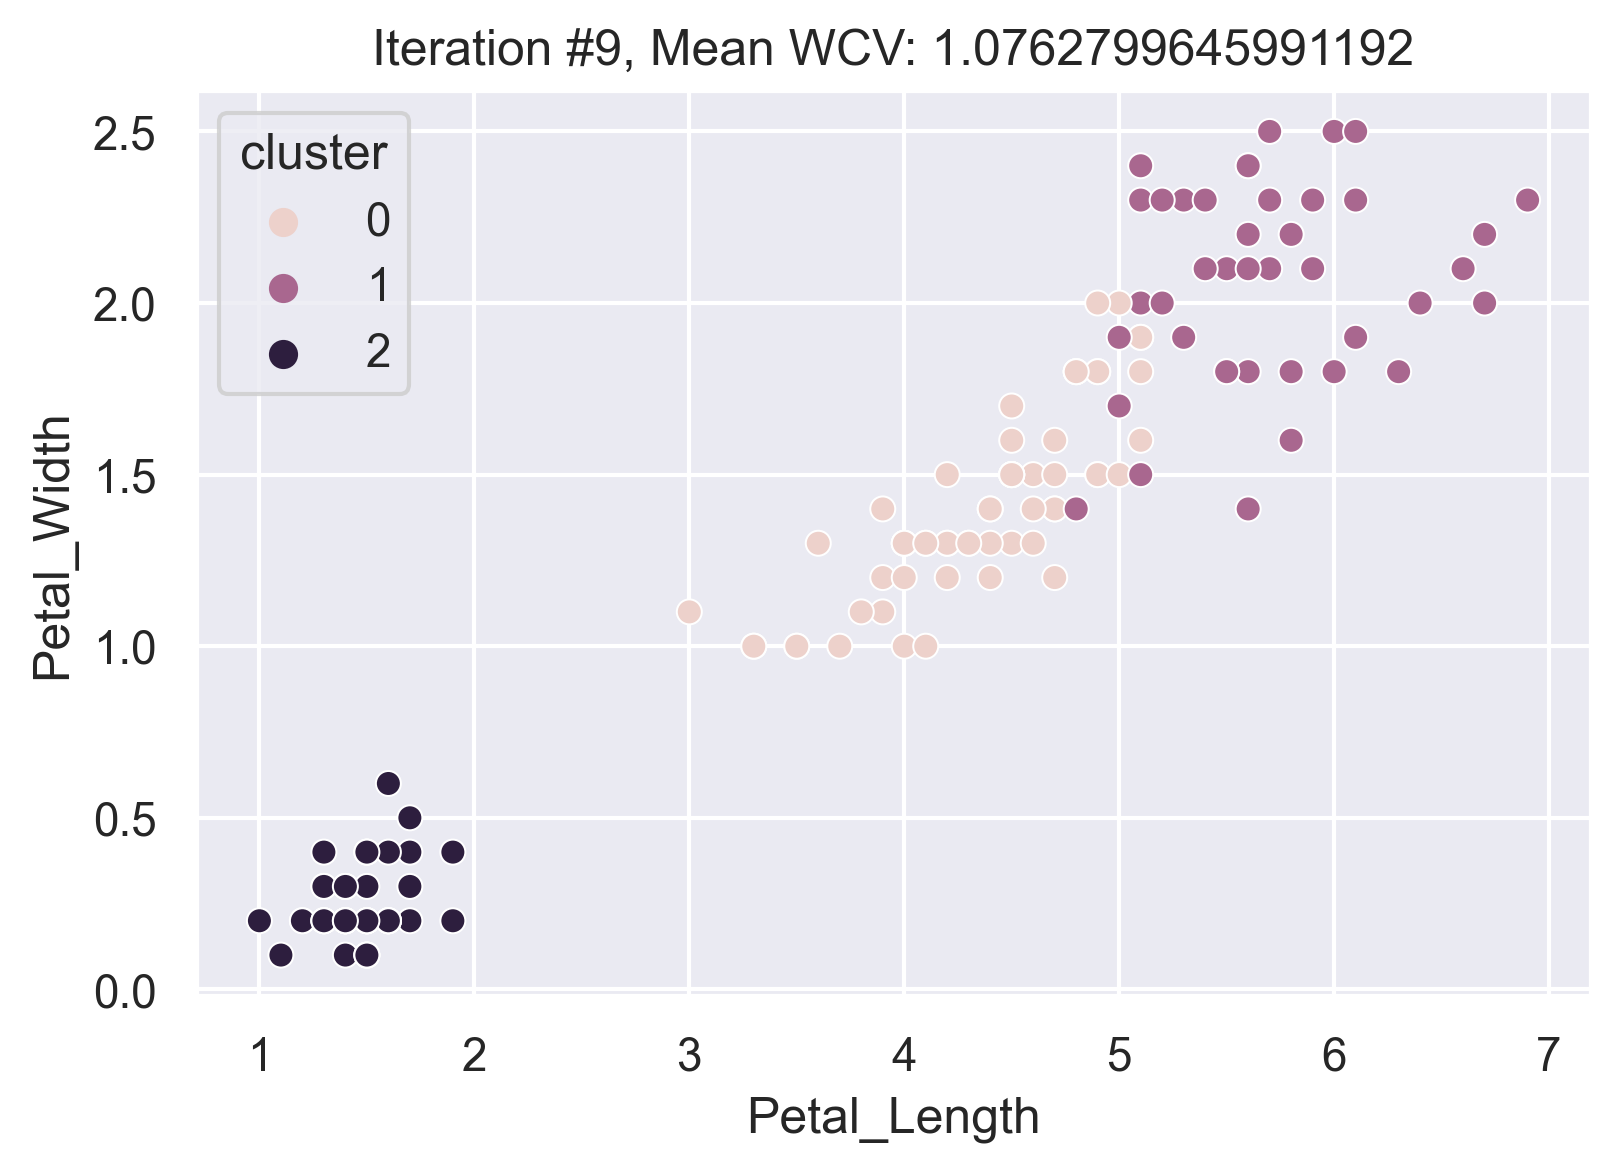

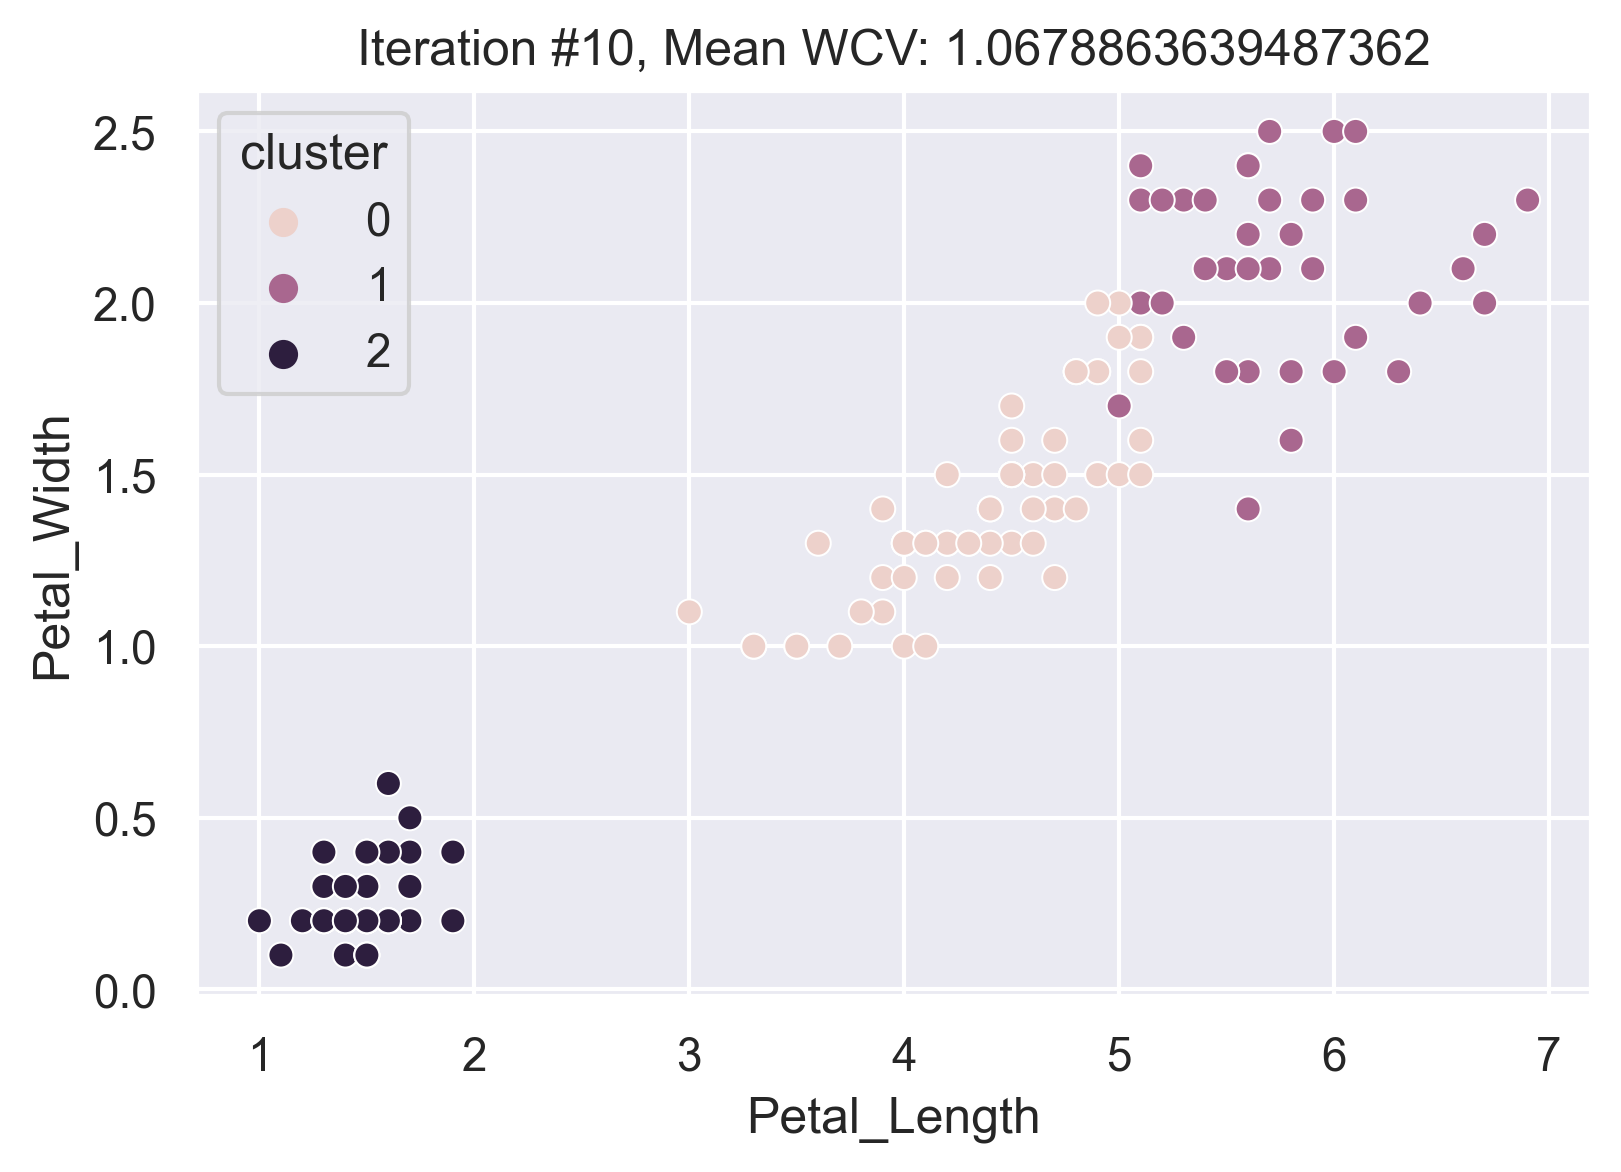

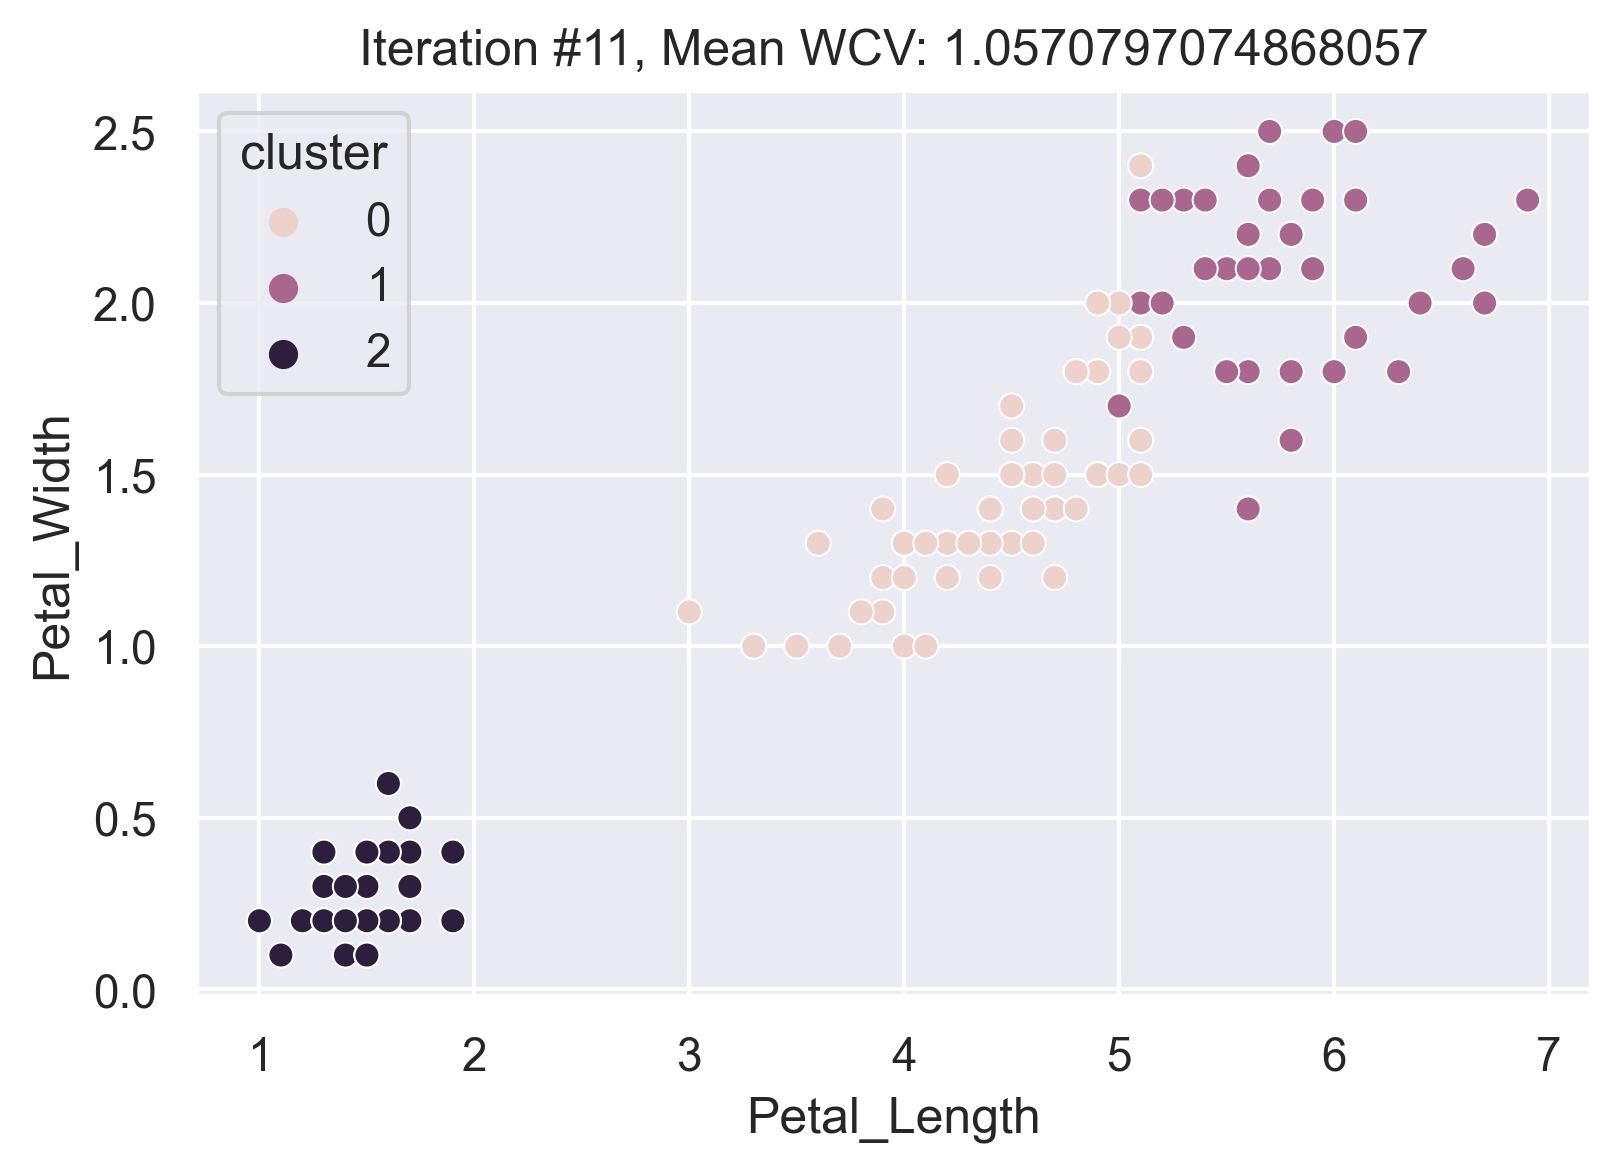

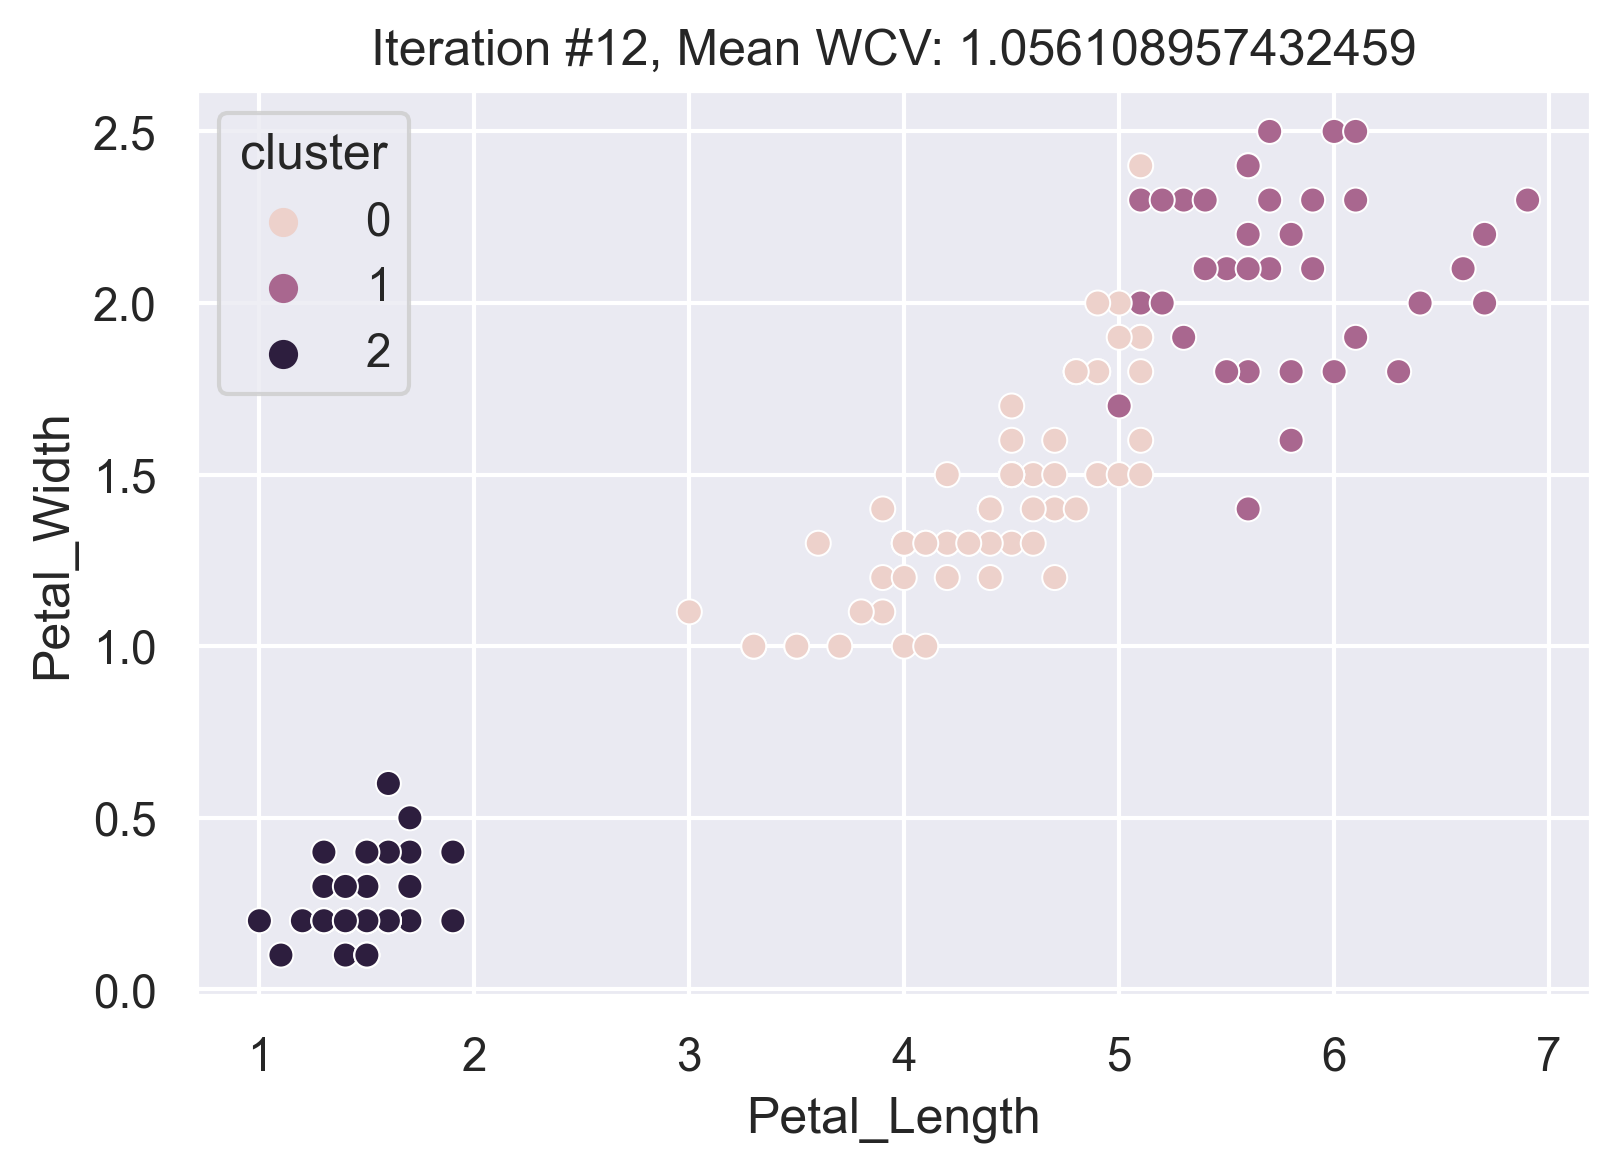

In [20]:
k_means = KMeans(df=iris, num_clusters=3)
k_means.fit(with_visualization=True)

مشاهده مي‌کنیم که در هر دوی اجراها، در هر پیمایش، معیار

wcv

کاهش پیدا می‌کند.

واضحاً هر چه تعداد خوشه‌ها را بالا ببریم، به

wcv

بهتری دست پیدا می‌کنیم. هر چند که ممکن است این تعداد خوشه، به خوبی نظم داده‌ها را بازنمایی نکند.